# Here is the Step4 about SHD Dataset

In [1]:
import pickle
import random
import numpy as np
from scipy import io
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as tnnf
from tqdm.notebook import tqdm
from utils import get_shd_dataset

ms = 1e-3 # use this constant so you can write e.g. 1*ms for a time

## Download SHD Dataset and Visualization

Available at: D:/forStudy/IRP/IRP_Neuro_SNN/dataset\hdspikes\shd_train.h5
Available at: D:/forStudy/IRP/IRP_Neuro_SNN/dataset\hdspikes\shd_test.h5
x_train['times'] shape: (8156,)
x_train['units'] shape: (8156,)
y_train shape: (8156,)
x_test['times'] shape: (2264,)
x_test['units'] shape: (2264,)
y_test shape: (2264,)


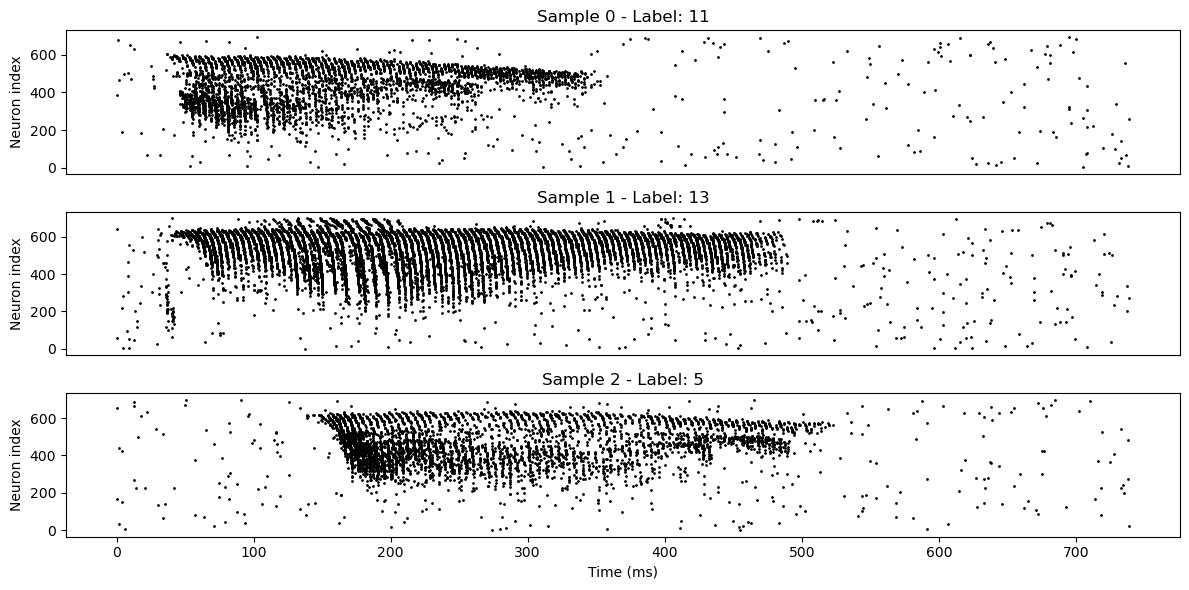

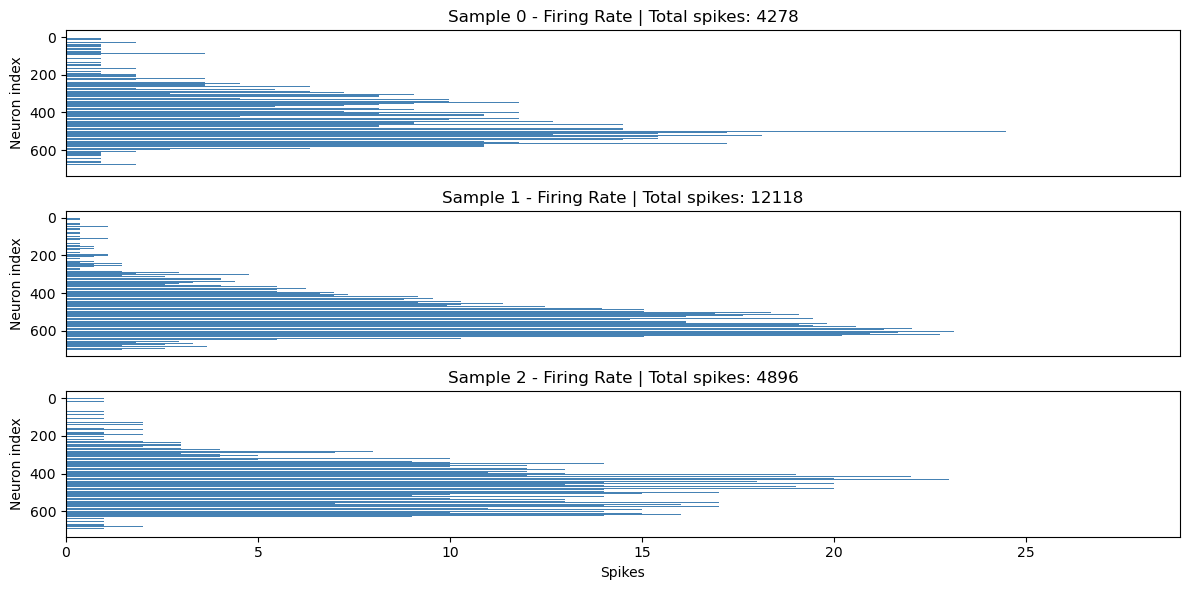

In [9]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

from utils import get_shd_dataset

cache_dir = "D:/forStudy/IRP/IRP_Neuro_SNN/dataset"
cache_subdir = "hdspikes"
get_shd_dataset(cache_dir, cache_subdir)

base_path = "D:/forStudy/IRP/IRP_Neuro_SNN/dataset/hdspikes"
train_path = os.path.join(base_path, "shd_train.h5")
train_file = h5py.File(train_path, "r")
test_path = os.path.join(base_path, "shd_test.h5")
test_file = h5py.File(test_path, "r")

x_train = train_file['spikes']
y_train = train_file['labels']
x_test = test_file['spikes']
y_test = test_file['labels']

n_neurons = 700
max_time = 1.4  
T = 1000     
time_resolution = 1.0
n_time_bins = int(T / time_resolution)

print("x_train['times'] shape:", x_train["times"].shape)
print("x_train['units'] shape:", x_train["units"].shape)
print("y_train shape:", y_train.shape)

print("x_test['times'] shape:", x_test["times"].shape)
print("x_test['units'] shape:", x_test["units"].shape)
print("y_test shape:", y_test.shape)

# ========== Dense spike train construction ==========
n_samples = 3
spike_trains = []
labels = []

for i in range(n_samples):
    times = x_train["times"][i] * 1000.0
    units = x_train["units"][i]
    label = y_train[i]
    
    spike_train = np.zeros((n_neurons, n_time_bins), dtype=int)
    for t, u in zip(times, units):
        t_idx = int(t / time_resolution)
        if 0 <= u < n_neurons and t_idx < n_time_bins:
            spike_train[u, t_idx] = 1

    spike_trains.append(spike_train)
    labels.append(label)

# ========== Raster Plot ==========
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(n_samples, 1)

for i, spike_train in enumerate(spike_trains):
    ax = plt.subplot(gs[i])
    for neuron_idx in range(spike_train.shape[0]):
        spike_times = np.where(spike_train[neuron_idx] == 1)[0]
        ax.scatter(spike_times, np.ones_like(spike_times) * neuron_idx, s=1, color='black')
    ax.set_ylabel("Neuron index")
    ax.set_title(f"Sample {i} - Label: {labels[i]}")
    if i == n_samples - 1:
        ax.set_xlabel("Time (ms)")
    else:
        ax.set_xticks([])

plt.tight_layout()
plt.show()

# ========== Firing Rate visualization ==========
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(n_samples, 1)

for i, spike_train in enumerate(spike_trains):
    ax = plt.subplot(gs[i])
    fr = spike_train.sum(axis=1)
    ax.barh(np.arange(len(fr)), fr, color='steelblue')
    ax.set_title(f"Sample {i} - Firing Rate | Total spikes: {fr.sum()}")
    ax.set_xlim([0, fr.max() + 5])
    ax.invert_yaxis()
    ax.set_ylabel("Neuron index")
    if i == n_samples - 1:
        ax.set_xlabel("Spikes")
    else:
        ax.set_xticks([])

plt.tight_layout()
plt.show()


## Split Dataset and Save as .mat

In [ ]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import io

cache_dir = "D:/forStudy/IRP/IRP_Neuro_SNN/dataset"
cache_subdir = "hdspikes"
get_shd_dataset(cache_dir, cache_subdir)

base_path = "D:/forStudy/IRP/IRP_Neuro_SNN/dataset/hdspikes"
train_path = os.path.join(base_path, "shd_train.h5")
train_file = h5py.File(train_path, "r")
test_path = os.path.join(base_path, "shd_test.h5")
test_file = h5py.File(test_path, "r")

x_train = train_file['spikes']
y_train = train_file['labels']
x_test = test_file['spikes']
y_test = test_file['labels']


batch_size = 256
nb_steps = 100
nb_units = 700
max_time = 1.4

def sparse_data_generator_from_hdf5_spikes(X, y, batch_size, nb_steps, nb_units, max_time, shuffle=True):
    labels_ = np.array(y, dtype=np.int32)
    number_of_batches = len(labels_) // batch_size
    sample_index = np.arange(len(labels_))
    firing_times = X['times']
    units_fired = X['units']
    time_bins = np.linspace(0, max_time, num=nb_steps)

    if shuffle:
        np.random.shuffle(sample_index)

    counter = 0
    while counter < number_of_batches:
        batch_index = sample_index[batch_size * counter : batch_size * (counter + 1)]
        dense_batch = np.zeros((batch_size, nb_units, nb_steps), dtype=np.uint8)
        y_batch = []

        for bc, idx in enumerate(batch_index):
            times = np.digitize(firing_times[idx], time_bins)
            units = units_fired[idx]
            # 防止越界
            times[times >= nb_steps] = nb_steps - 1
            dense_batch[bc, units, times] = 1
            y_batch.append(labels_[idx])

        yield dense_batch, np.array(y_batch, dtype=np.uint8)
        counter += 1

def collect_all(X_h5, Y_h5):
    X_all = []
    Y_all = []
    gen = sparse_data_generator_from_hdf5_spikes(X_h5, Y_h5,
                                                 batch_size, nb_steps,
                                                 nb_units, max_time,
                                                 shuffle=False)
    for x_batch, y_batch in gen:
        X_all.append(x_batch)
        Y_all.append(y_batch)
    X_all = np.concatenate(X_all, axis=0)  # shape: (N, 700, 100)
    Y_all = np.concatenate(Y_all, axis=0)  # shape: (N,)
    return X_all, Y_all

X_train_all, Y_train_all = collect_all(x_train, y_train)
X_test_all,  Y_test_all  = collect_all(x_test,  y_test)

X_all = np.concatenate([X_train_all, X_test_all], axis=0)
Y_all = np.concatenate([Y_train_all, Y_test_all], axis=0)

print("Original Shape:", X_all.shape, Y_all.shape)


import numpy as np

def create_min_count_dataset_avoid_widespread(
    X, Y,
    neuron_threshold=2,
    max_frac_for_neuron=0.01,    # 若一个神经元有>5%的样本低于阈值 => 视为普遍现象, 不删
    max_samples_to_remove=1000
):
    """
    思路：
      1) 对每个神经元 f, 先看它的最小发放数(被某些样本拉到 < neuron_threshold?).
      2) 若是坏神经元, 则看它有多少样本 count[f] < neuron_threshold:
         - 如果这个数量 bad_count 超过 (max_frac_for_neuron * N), 说明是“普遍现象”，不删它对应的样本;
         - 否则, 把这部分样本加入删除集合 samples_to_remove
      3) 如果最终 samples_to_remove 总数 < max_samples_to_remove, 则删除这些样本
         否则，不删
      4) 在剩余数据上做 do_min_count, 返回 (X_min, Y_new)
    参数：
      - neuron_threshold: 神经元若被某些样本拉到 min_count < neuron_threshold，就视为“坏神经元”
      - max_frac_for_neuron: 对坏神经元做进一步判断，若有超过此比例的样本都使它低于阈值，就视为“遍布”问题，不删
      - max_samples_to_remove: 最多愿意删除多少样本
    """

    N, F, T = X.shape
    counts = X.sum(axis=2)   # shape (N, F)
    # 每个神经元 f 的最小发放数
    min_counts_per_neuron = counts.min(axis=0)  # shape: (F,)

    # 找到所有坏神经元
    bad_neurons = np.where(min_counts_per_neuron < neuron_threshold)[0]
    num_bad_neurons = len(bad_neurons)
    print(f"Found {num_bad_neurons} neurons with min_count < {neuron_threshold}.")

    if num_bad_neurons == 0:
        print("No neuron is below threshold; skip removing => do min-count only.")
        return do_min_count(X, Y)

    samples_to_remove = set()

    for f_idx in bad_neurons:
        # 该神经元在各样本的脉冲数
        neuron_counts = counts[:, f_idx]
        # i_bad: 样本索引，使得 这个神经元 < neuron_threshold
        i_bad = np.where(neuron_counts < neuron_threshold)[0]
        bad_count = len(i_bad)
        frac = bad_count / N
        # 如果这个坏神经元在超过 max_frac_for_neuron 的样本里都低于阈值 => 说明是普遍问题，不删
        if frac > max_frac_for_neuron:
            # 跳过，不删
            continue
        else:
            # 只是一部分样本, 可以删
            for i_idx in i_bad:
                samples_to_remove.add(i_idx)

    n_remove = len(samples_to_remove)
    print(f"Total collected {n_remove} samples to remove from partial neurons (~ local problem).")

    # 全局判断: 如果要删的样本太多, 就不删
    if 0 < n_remove < max_samples_to_remove:
        print(f"Removing {n_remove} samples (less than limit={max_samples_to_remove}).")
        keep_idxs = np.setdiff1d(np.arange(N), list(samples_to_remove))
        X_filtered = X[keep_idxs]
        Y_filtered = Y[keep_idxs]
    else:
        print(f"NOT removing samples; n_remove={n_remove} >= max_samples_to_remove={max_samples_to_remove} or n_remove=0.")
        X_filtered = X
        Y_filtered = Y

    # 在过滤后的数据上做 min-count
    return do_min_count(X_filtered, Y_filtered)


def do_min_count(X, Y):
    """
    与之前相同：对 (X, Y) 做 min-count 操作：
      - 对每个神经元 f, 找 min 发放数 N_f
      - 在每个样本中只保留 N_f 个脉冲
    """
    N, F, T = X.shape
    count_all = X.sum(axis=2)      # (N, F)
    min_counts = count_all.min(axis=0)

    X_min = np.zeros_like(X)
    for f_idx in range(F):
        N_f = min_counts[f_idx]
        if N_f == 0:
            continue
        for i_idx in range(N):
            spike_times = np.where(X[i_idx, f_idx, :] == 1)[0]
            if len(spike_times) > N_f:
                chosen_times = np.random.choice(spike_times, size=N_f, replace=False)
                X_min[i_idx, f_idx, chosen_times] = 1
            else:
                X_min[i_idx, f_idx, spike_times] = 1

    return X_min, Y


X_min, Y_new = create_min_count_dataset_avoid_widespread(
    X_all, Y_all,
    neuron_threshold=2,       # 对神经元最小发放数的阈值
    max_frac_for_neuron=0.005, # 若>0.5%的样本都把某神经元拉低，则认为是普遍问题
    max_samples_to_remove=1000
)
print("After removing extreme samples + min-count, shape =", X_min.shape, Y_new.shape)

save_path_4 = "D:/forStudy/IRP/IRP_Neuro_SNN/spikedata4_1.mat"
io.savemat(save_path_4, {"X": X_min, "Y": Y_new})
print(f"Saved filtered dataset to {save_path_4}")

Available at: D:/forStudy/IRP/IRP_Neuro_SNN/dataset\hdspikes\shd_train.h5
Available at: D:/forStudy/IRP/IRP_Neuro_SNN/dataset\hdspikes\shd_test.h5
Original Shape: (9984, 700, 100) (9984,)
Found 691 neurons with min_count < 2.
Total collected 610 samples to remove from partial neurons (~ local problem).
Removing 610 samples (less than limit=1000).
After removing extreme samples + min-count, shape = (9374, 700, 100) (9374,)
Saved filtered dataset to D:/forStudy/IRP/IRP_Neuro_SNN/spikedata4_1.mat


In [17]:
X_min, Y_new = create_min_count_dataset_avoid_widespread(
    X_all, Y_all,
    neuron_threshold=2,       # 对神经元最小发放数的阈值
    max_frac_for_neuron=0.01, # 若>1%的样本都把某神经元拉低，则认为是普遍问题
    max_samples_to_remove=2000
)
print("After removing extreme samples + min-count, shape =", X_min.shape, Y_new.shape)

save_path_4 = "D:/forStudy/IRP/IRP_Neuro_SNN/spikedata4_2.mat"
io.savemat(save_path_4, {"X": X_min, "Y": Y_new})
print(f"Saved filtered dataset to {save_path_4}")

Found 691 neurons with min_count < 2.
Total collected 1037 samples to remove from partial neurons (~ local problem).
Removing 1037 samples (less than limit=2000).
After removing extreme samples + min-count, shape = (8947, 700, 100) (8947,)
Saved filtered dataset to D:/forStudy/IRP/IRP_Neuro_SNN/spikedata4_2.mat


X shape: (8947, 700, 100) Y shape: (8947,)

--- Sample counts per class ---
Class 0: 474 samples
Class 1: 474 samples
Class 2: 273 samples
Class 3: 366 samples
Class 4: 462 samples
Class 5: 453 samples
Class 6: 372 samples
Class 7: 446 samples
Class 8: 385 samples
Class 9: 482 samples
Class 10: 484 samples
Class 11: 506 samples
Class 12: 504 samples
Class 13: 502 samples
Class 14: 452 samples
Class 15: 443 samples
Class 16: 491 samples
Class 17: 458 samples
Class 18: 405 samples
Class 19: 515 samples

--- getting a batch from generator ---
x_batch: (4, 700, 100) y_batch: [ 0  1 15 11]


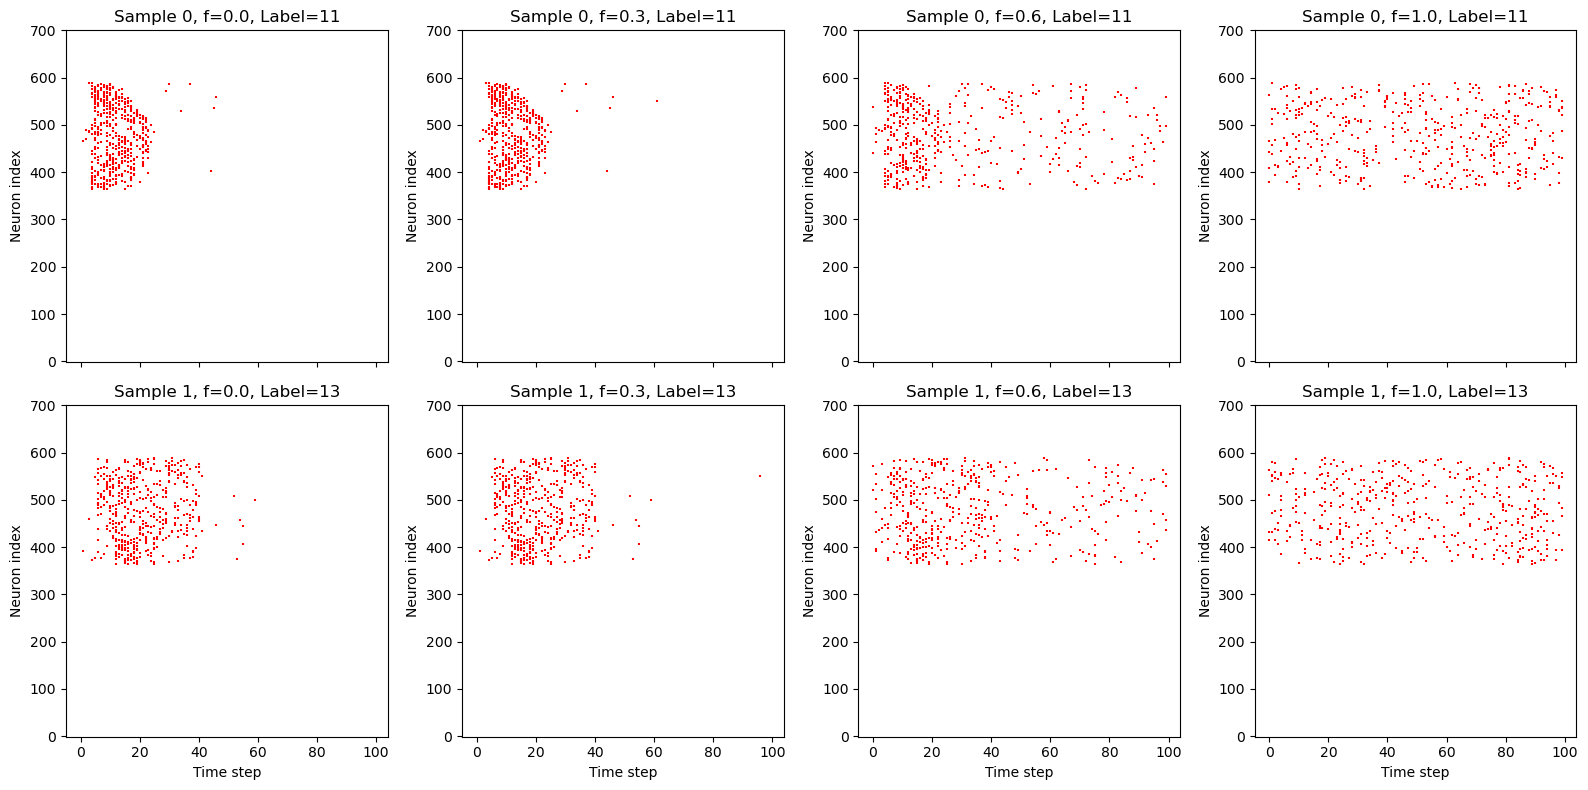

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

mat_path = "D:/forStudy/IRP/IRP_Neuro_SNN/spikedata4_2.mat"
data = loadmat(mat_path)
X = data["X"]  # shape (N, 700, 100)
Y = data["Y"].flatten()  # shape (N,)

N, n_neurons, T = X.shape
print("X shape:", X.shape, "Y shape:", Y.shape)

def partial_randomize_spike_train(spike_train, f=0.5, max_attempts=50):

    num_neurons, T = spike_train.shape
    new_train = np.copy(spike_train)

    for neuron_idx in range(num_neurons):
        spike_times = np.where(spike_train[neuron_idx] == 1)[0]
        if len(spike_times) == 0:
            continue

        num_to_jitter = int(len(spike_times) * f)
        if num_to_jitter < 1:
            continue

        chosen_times = np.random.choice(spike_times, size=num_to_jitter, replace=False)
        new_train[neuron_idx, chosen_times] = 0

        attempts = 0
        inserted = 0
        while inserted < num_to_jitter and attempts < max_attempts * num_to_jitter:
            attempts += 1
            new_t = np.random.randint(0, T)
            if new_train[neuron_idx, new_t] == 0:
                new_train[neuron_idx, new_t] = 1
                inserted += 1

    return new_train

def data_generator_with_randomization(X, Y, batch_size=4, f=0.5, shuffle=True):
    """
    generator: generater for (x_batch, y_batch) with partial randomization
      - X.shape = (N, n_neurons, T)
      - Y.shape = (N,)
    do partial randomization when generating batches rather than all data
    """
    N = len(Y)
    indices = np.arange(N)
    if shuffle:
        np.random.shuffle(indices)

    num_batches = N // batch_size
    for b in range(num_batches):
        batch_idx = indices[b * batch_size : (b + 1) * batch_size]

        x_batch = np.zeros((batch_size, X.shape[1], X.shape[2]), dtype=np.uint8)
        y_batch = np.zeros((batch_size,), dtype=np.int32)

        for i, idx in enumerate(batch_idx):
            x_randomized = partial_randomize_spike_train(X[idx], f=f)
            x_batch[i] = x_randomized
            y_batch[i] = Y[idx]

        yield x_batch, y_batch

# 统计每个类别的样本数量
def count_samples_per_class(Y):
    """
    Count the number of samples for each class in the dataset.
    Args:
        Y: numpy array of shape (N,), where N is the number of samples.
    Returns:
        A dictionary where keys are class labels and values are sample counts.
    """
    unique_classes, counts = np.unique(Y, return_counts=True)
    class_counts = {cls: count for cls, count in zip(unique_classes, counts)}
    return class_counts

# 调用统计函数
class_counts = count_samples_per_class(Y)

# 打印统计结果
print("\n--- Sample counts per class ---")
for cls, count in class_counts.items():
    print(f"Class {cls}: {count} samples")

print("\n--- getting a batch from generator ---")
gen = data_generator_with_randomization(X, Y, batch_size=4, f=0.3, shuffle=True)
x_batch, y_batch = next(gen)
print("x_batch:", x_batch.shape, "y_batch:", y_batch)

# 3) visualization: for the same sample, test the effect of different f
sample_indexes = [0, 1]
f_values = [0.0, 0.3, 0.6, 1.0]

fig, axes = plt.subplots(len(sample_indexes), len(f_values), figsize=(16, 8), sharex=True)
if len(sample_indexes) == 1:
    axes = [axes]

for i, sample_idx in enumerate(sample_indexes):
    label = Y[sample_idx] 
    
    for j, f_val in enumerate(f_values):
        randomized_train = partial_randomize_spike_train(X[sample_idx], f=f_val)
        
        ax = axes[i][j] if len(sample_indexes)>1 else axes[j]

        for neuron_idx in range(randomized_train.shape[0]):
            spike_times = np.where(randomized_train[neuron_idx] == 1)[0]
            ax.scatter(spike_times, np.ones_like(spike_times)*neuron_idx,
                       s=2, marker='|', color='red')

        ax.set_title(f"Sample {sample_idx}, f={f_val}, Label={label}")
        ax.set_ylabel("Neuron index")
        ax.set_ylim(-1, randomized_train.shape[0])
        if i == len(sample_indexes) - 1:
            ax.set_xlabel("Time step")

plt.tight_layout()
plt.show()


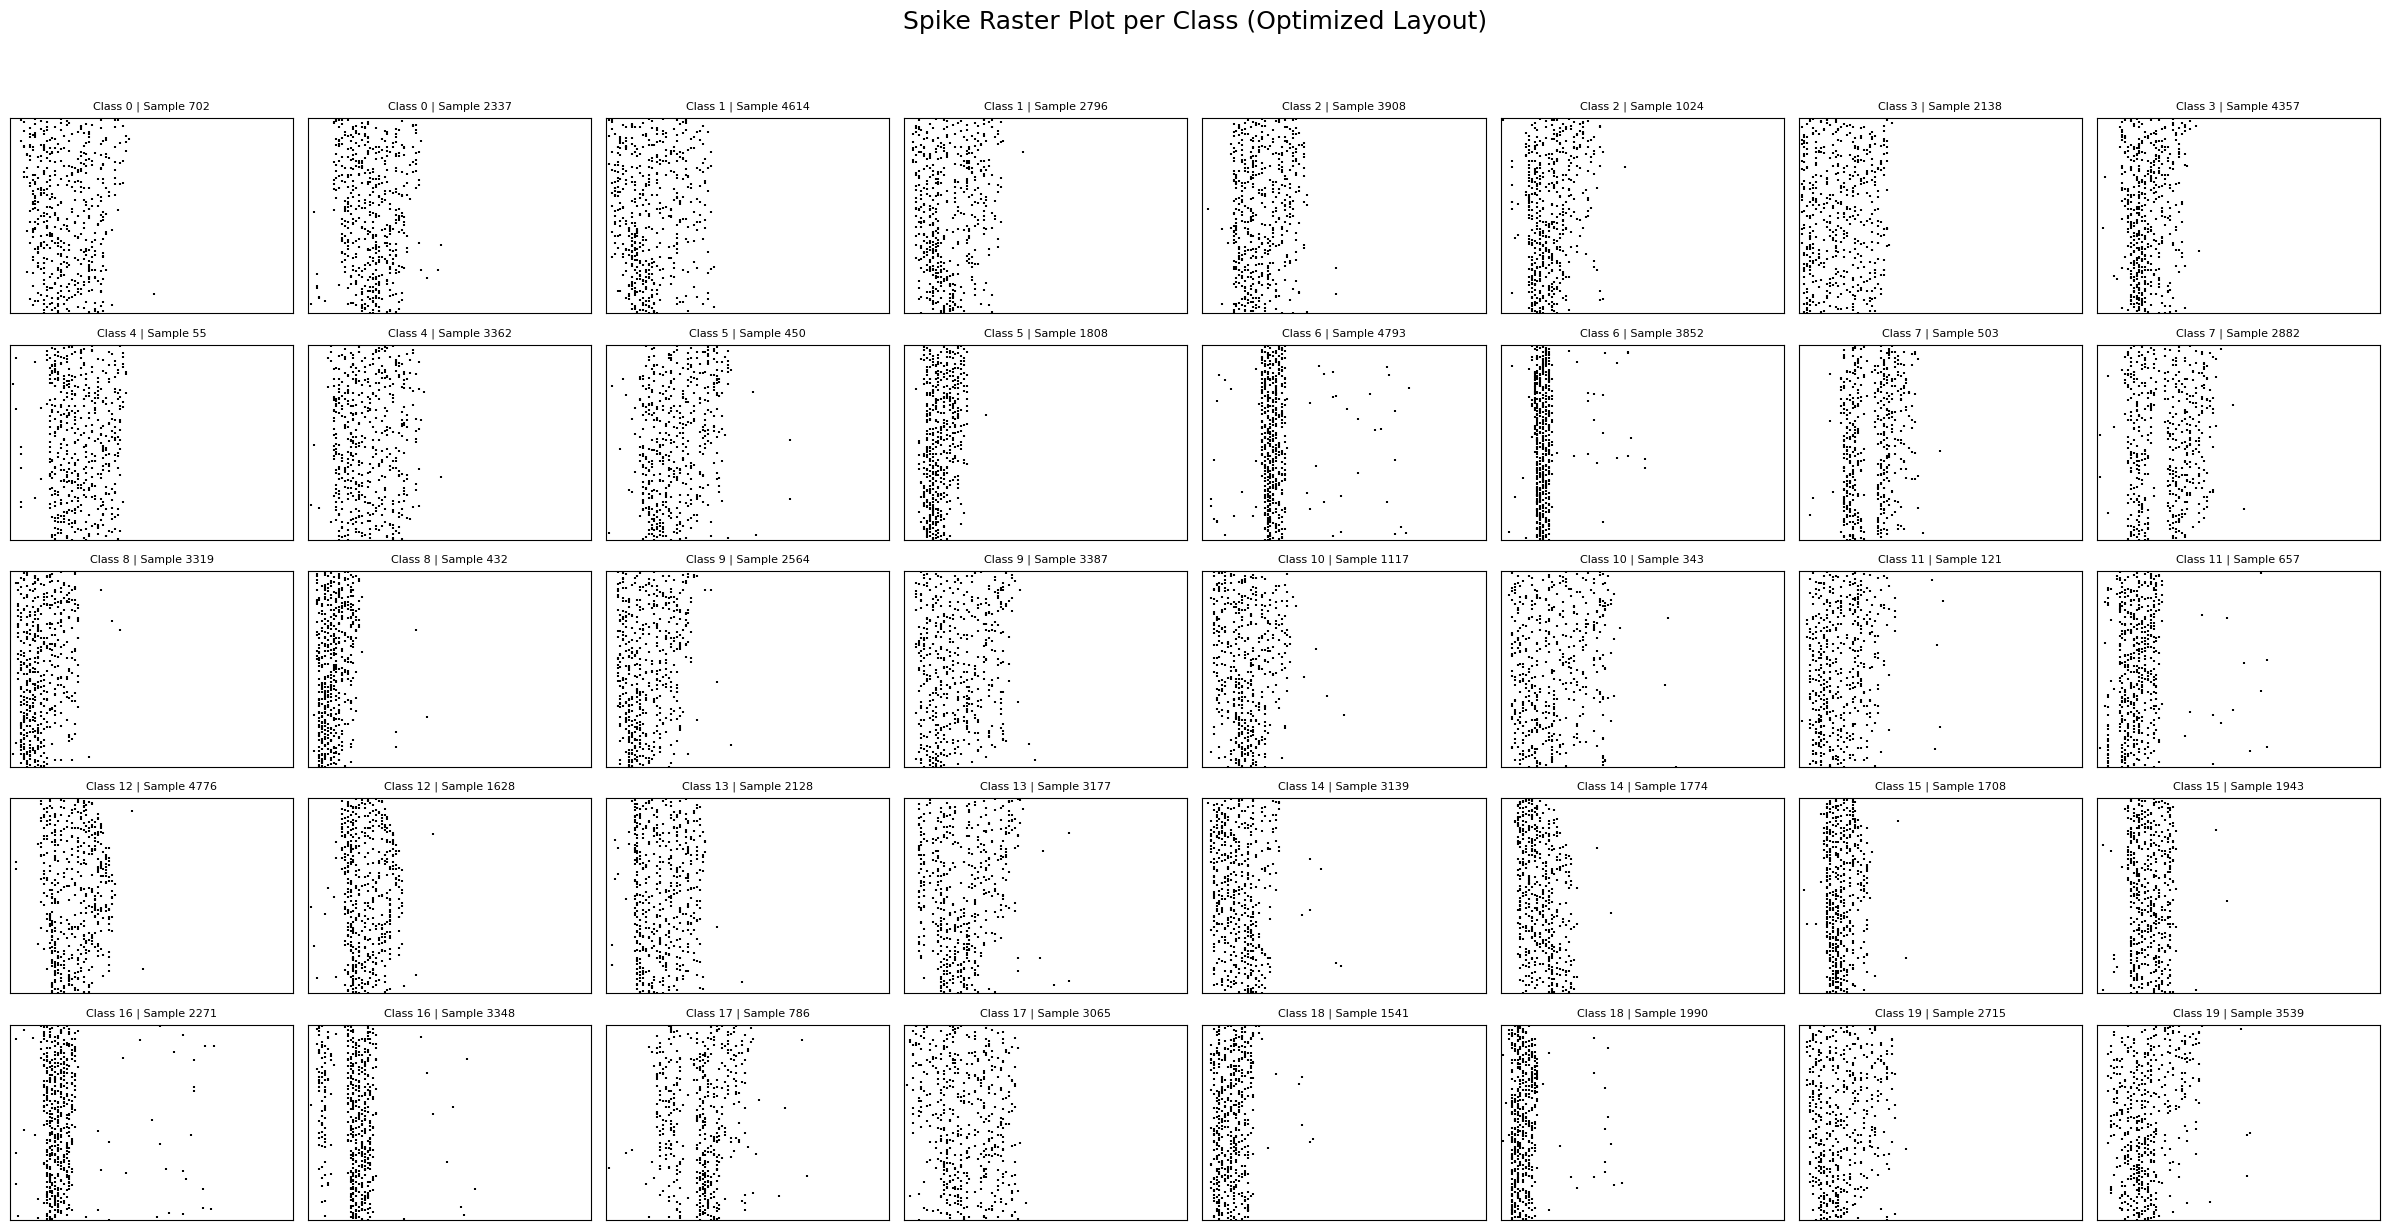

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
import math

data = io.loadmat('spikedata4_3.mat')
X = data['X']  # shape = (N, num_neurons, T)
Y = data['Y'].ravel()

N, num_neurons, T = X.shape
unique_labels = np.unique(Y)
num_classes = len(unique_labels)

num_samples_per_class = 2
total_plots = num_classes * num_samples_per_class

ncols = 8
nrows = math.ceil(total_plots / ncols)

np.random.seed(42)
selected_samples = []
for cls in unique_labels:
    cls_indices = np.where(Y == cls)[0]
    selected = np.random.choice(cls_indices, size=num_samples_per_class, replace=False)
    selected_samples.extend([(int(cls), idx) for idx in selected])

# Visualization
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 2.5*nrows), sharex=True, sharey=True)
axes = axes.flatten()
fig.suptitle("Spike Raster Plot per Class (Optimized Layout)", fontsize=18)

for i, (cls, sample_idx) in enumerate(selected_samples):
    ax = axes[i]
    spike_mat = X[sample_idx, :, :]
    for neuron_idx in range(num_neurons):
        spike_times = np.where(spike_mat[neuron_idx] == 1)[0]
        ax.scatter(spike_times, np.ones_like(spike_times)*neuron_idx,
                   s=1.5, marker='|', color='black')

    ax.set_title(f"Class {cls} | Sample {sample_idx}", fontsize=8)
    ax.set_xlim([0, T])
    ax.set_ylim([0, num_neurons])
    ax.set_xticks([])
    ax.set_yticks([])

for j in range(len(selected_samples), len(axes)):
    axes[j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Dataset shape: X=(5460, 224, 100), Y=(5460)
There are 0 neurons that are 0 in all samples
There are 0 samples that are 0 in all neurons/time
 Each sample's total spikes: Average: 471.00, std: 0.00, min: 471, max: 471


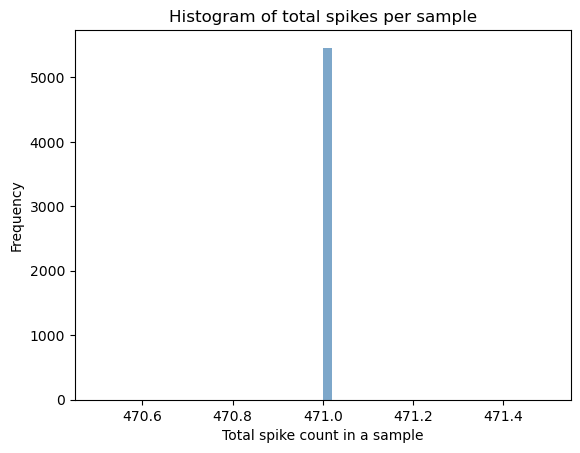

In [4]:
import numpy as np
from scipy import io

# 载入 spikedata4.mat
data = io.loadmat('spikedata4_3.mat')
X = data['X']  # shape = (N, F, T)
Y = data['Y'].ravel()  # (N, )

N, F, T = X.shape
print(f"Dataset shape: X=({N}, {F}, {T}), Y=({len(Y)})")

# 1) 统计多少神经元在所有样本上均为0
#    即针对神经元 f，查看其在全部 (N, T) 上的脉冲和是否为 0
#    sum_over_all[i, f, t] => sum_over_samples_time => shape (F,)
sum_over_samples_time = X.sum(axis=(0, 2))  # 沿着样本维(N)和时间维(T)求和 => (F,)
num_neurons_all_zero = np.sum(sum_over_samples_time == 0)
print(f"There are {num_neurons_all_zero} neurons that are 0 in all samples")


# 2) 统计多少样本在所有神经元/时间上均为0
#    即针对样本 i，查看其在全部 (F, T) 上的脉冲和是否为 0
sum_over_neurons_time = X.sum(axis=(1, 2))  # 沿着神经元维(F)和时间维(T)求和 => (N,)
num_samples_all_zero = np.sum(sum_over_neurons_time == 0)
print(f"There are {num_samples_all_zero} samples that are 0 in all neurons/time")

# 3) 可选：查看每个样本的脉冲总数分布，了解是否很多样本脉冲数极少
non_zero_spikes_per_sample = sum_over_neurons_time  # 每个样本的总脉冲数
avg_spikes = np.mean(non_zero_spikes_per_sample)
std_spikes = np.std(non_zero_spikes_per_sample)
max_spikes = np.max(non_zero_spikes_per_sample)
min_spikes = np.min(non_zero_spikes_per_sample)

print(f" Each sample's total spikes: Average: {avg_spikes:.2f}, std: {std_spikes:.2f}, "
      f"min: {min_spikes}, max: {max_spikes}")

# 如果还想看一下分布，比如直方图:
import matplotlib.pyplot as plt

plt.hist(non_zero_spikes_per_sample, bins=50, color='steelblue', alpha=0.7)
plt.title("Histogram of total spikes per sample")
plt.xlabel("Total spike count in a sample")
plt.ylabel("Frequency")
plt.show()


In [21]:
import numpy as np
from scipy import io

data = io.loadmat("spikedata4_2.mat")
X = data["X"]  # shape (N, 700, T)
Y = data["Y"].ravel()

N, F, T = X.shape
print("Before dropping zero neurons:", X.shape)

# 1) 找出哪些神经元在所有样本上都是 0
sum_over_samples_time = X.sum(axis=(0, 2))   # shape (F,)
zero_mask = (sum_over_samples_time == 0)     # shape (F,)

num_zero_neurons = np.sum(zero_mask)
print(f"There are {num_zero_neurons} neurons that are 0 in all samples.")

# 2) 构造非零神经元的 mask，并保留对应列
non_zero_mask = ~zero_mask
X_new = X[:, non_zero_mask, :]  # shape (N, F_new, T)
F_new = X_new.shape[1]
print(f"After dropping zero neurons, shape: {X_new.shape}")

# 如果需要保存新的数据集
io.savemat("spikedata4_2_trimmed.mat", {"X": X_new, "Y": Y})


Before dropping zero neurons: (8947, 700, 100)
There are 476 neurons that are 0 in all samples.
After dropping zero neurons, shape: (8947, 224, 100)


## Begin Here to Train

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import random

# -------------- 1) 载入原数据 --------------
data = loadmat("spikedata4_2_trimmed.mat")
X_full = data["X"]        # shape = (N, num_neurons, T)
Y_full = data["Y"].ravel()# shape = (N,)

N, num_neurons, T = X_full.shape
print(f"Loaded trimmed dataset: X_full.shape=({N},{num_neurons},{T}), Y_full.shape=({len(Y_full)})")

# -------------- 2) 统计每个类别样本数，找到最小样本数 --------------
unique_labels = np.unique(Y_full)
counts_per_class = {}
for c in unique_labels:
    idxs_c = np.where(Y_full == c)[0]
    counts_per_class[c] = len(idxs_c)

print("--- Sample counts per class ---")
for c in sorted(unique_labels):
    print(f"Class {c}: {counts_per_class[c]} samples")

# 假设你已经知道最少的样本数是 Class 2 => 121
# 或者你想自动获取最小值:
min_count = min(counts_per_class.values())
print(f"The minimal sample count among classes = {min_count}")

# -------------- 3) 为了平衡数据集，截断各类别到 min_count --------------
X_list = []
Y_list = []

for c in sorted(unique_labels):
    idxs_c = np.where(Y_full == c)[0]
    np.random.shuffle(idxs_c)   # 打乱该类别内部顺序
    selected = idxs_c[:min_count]  # 只保留前 min_count 个
    X_list.append(X_full[selected])
    Y_list.append(Y_full[selected])

X_bal = np.concatenate(X_list, axis=0)
Y_bal = np.concatenate(Y_list, axis=0)

print(f"Balanced dataset shape before shuffle: X_bal=({X_bal.shape}), Y_bal=({Y_bal.shape})")

# -------------- 4) 再次全局 shuffle，打乱类别顺序 --------------
perm = np.random.permutation(len(Y_bal))
X_bal = X_bal[perm]
Y_bal = Y_bal[perm]

print(f"After balancing & shuffle: X_bal=({X_bal.shape}), Y_bal=({Y_bal.shape})")

# -------------- 5) 后续保存 / 或直接传给训练 --------------
# (a) 直接保存
import scipy.io as io
save_path_bal = "spikedata4_3.mat"
io.savemat(save_path_bal, {"X": X_bal, "Y": Y_bal})
print(f"Saved balanced dataset to: {save_path_bal}")

# (b) 或者交给后续 partial randomization / batched_data() ...
# 例如:
# from your_script import batched_data
# for x_batch, y_batch in batched_data(..., X=X_bal, Y=Y_bal):
#     ...


Loaded trimmed dataset: X_full.shape=(8947,224,100), Y_full.shape=(8947)
--- Sample counts per class ---
Class 0: 474 samples
Class 1: 474 samples
Class 2: 273 samples
Class 3: 366 samples
Class 4: 462 samples
Class 5: 453 samples
Class 6: 372 samples
Class 7: 446 samples
Class 8: 385 samples
Class 9: 482 samples
Class 10: 484 samples
Class 11: 506 samples
Class 12: 504 samples
Class 13: 502 samples
Class 14: 452 samples
Class 15: 443 samples
Class 16: 491 samples
Class 17: 458 samples
Class 18: 405 samples
Class 19: 515 samples
The minimal sample count among classes = 273
Balanced dataset shape before shuffle: X_bal=((5460, 224, 100)), Y_bal=((5460,))
After balancing & shuffle: X_bal=((5460, 224, 100)), Y_bal=((5460,))
Saved balanced dataset to: spikedata4_3.mat


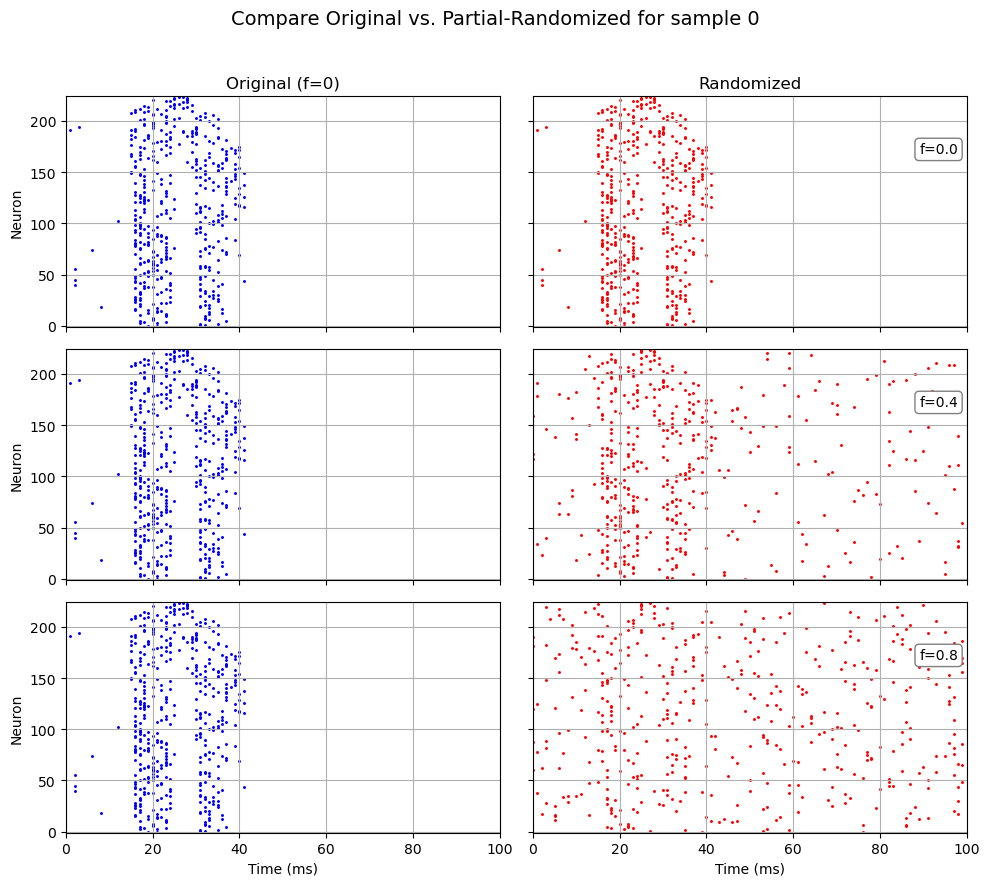

Using data index range = [0, 3276), total 3276 samples
batch_size=2
num_time_points=100
num_batches=1638
RAM usage per batch ~ 0.0003 GB
Got a batch: x_batch.shape=(2, 224, 100), y_batch=[7 3]


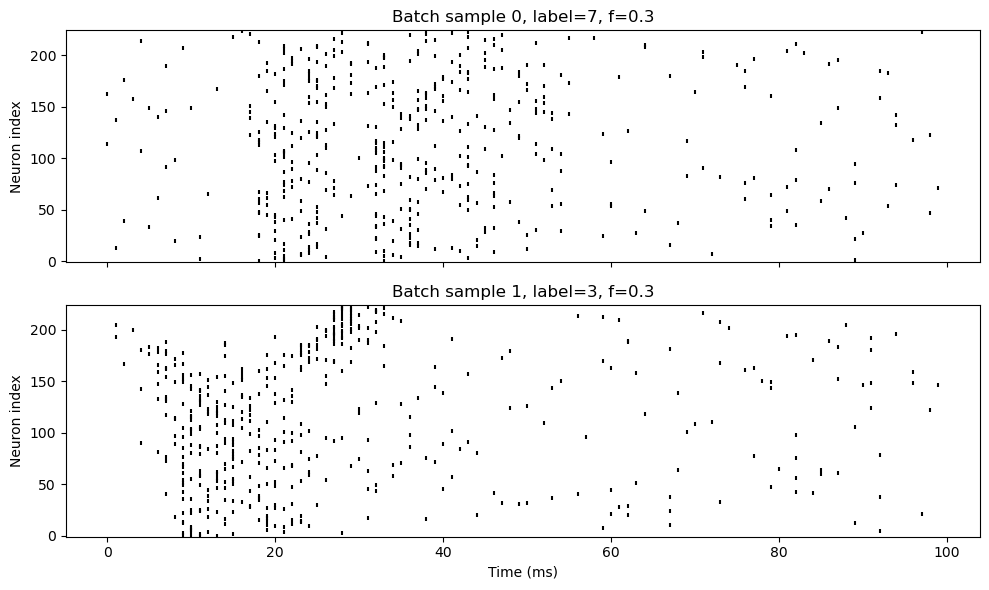

In [5]:
import numpy as np
import matplotlib.pyplot as plt


def partial_randomize_spike_train(spike_train, f=0.5, max_attempts=500):
    """
    对单个 spike_train 做部分随机化：
      - 对每个脉冲，以概率 f 决定是否移动到新的时间位置。
      - 若移动，则先将原位置置 0，再尝试在随机时间 new_t 插入 1。
      - 不允许同一神经元同一时刻放置两个脉冲（若冲突则重试，直到达 max_attempts).
    参数：
      spike_train.shape = (num_neurons, T)
      f：每个脉冲移动的概率 (0~1)
      max_attempts：为同一个 spike 重新插入时最多尝试多少次
    返回：与 spike_train 同形状的 new_train
    """
    # 如果 f=0 或 f<0，直接返回原始数据不做处理
    if f <= 0:
        return spike_train

    num_neurons, T = spike_train.shape
    # 复制一下，以免改动原数据
    new_train = np.copy(spike_train)

    for neuron_idx in range(num_neurons):
        # 找到该神经元所有脉冲的时刻
        spike_times = np.where(spike_train[neuron_idx] == 1)[0]
        for old_time in spike_times:
            # 以概率 f 决定是否移动这个 spike
            if np.random.rand() < f:
                # 1) 先把旧位置的脉冲清除
                new_train[neuron_idx, old_time] = 0

                # 2) 在新的时间位置插入
                inserted = False
                attempts = 0
                while not inserted and attempts < max_attempts:
                    attempts += 1
                    new_t = np.random.randint(0, T)  # 随机一个新时刻
                    if new_train[neuron_idx, new_t] == 0:
                        new_train[neuron_idx, new_t] = 1
                        inserted = True
                # 如果 attempts 用完还没插进去，就不再插这个 spike 
                # （极端情况下可能导致脉冲总数略有减少）

    return new_train

    
def num_batches_if(time_fractions, batch_size=32, max_num_batches=None):
    """
    return how many batches can be generated in the given time_fractions
    """
    f_start, f_end = time_fractions
    N = X.shape[0]
    start_idx = int(round(N * f_start))
    end_idx   = int(round(N * f_end))
    sub_len = end_idx - start_idx
    n_batches = sub_len // batch_size
    if max_num_batches is not None:
        n_batches = min(n_batches, max_num_batches)
    return n_batches

def batched_data(time_fractions, X, Y, batch_size=4, f=0.5,
                 verbose=False, shuffle=True, max_num_batches=None,
                 max_attempts=50):
    """
    for (x_batch, y_batch) in batched_data(...):
        # x_batch.shape = (batch_size, n_neurons, T)
        # y_batch.shape = (batch_size,)
    """
    N = len(Y)
    f_start, f_end = time_fractions
    start_idx = int(round(N * f_start))
    end_idx   = int(round(N * f_end))
    subX = X[start_idx:end_idx]  # [sub_len, n_neurons, T]
    subY = Y[start_idx:end_idx]  # [sub_len]
    sub_len = len(subY)

    indices = np.arange(sub_len)
    if shuffle:
        np.random.shuffle(indices)

    num_batches = sub_len // batch_size
    if max_num_batches is not None:
        num_batches = min(num_batches, max_num_batches)

    num_neurons = X.shape[1]
    num_time_points = X.shape[2]

    if verbose:
        print(f"Using data index range = [{start_idx}, {end_idx}), total {sub_len} samples")
        print(f"{batch_size=}")
        print(f"{num_time_points=}")
        print(f"{num_batches=}")
        print(f"RAM usage per batch ~ {batch_size * num_time_points * num_neurons * 8 / (1024)**3:.4f} GB")

    for b in range(num_batches):
        batch_idx = indices[b*batch_size : (b+1)*batch_size]
        x_batch = np.zeros((batch_size, subX.shape[1], subX.shape[2]), dtype=np.uint8)
        y_batch = np.zeros((batch_size,), dtype=np.int32)
        for i, sidx in enumerate(batch_idx):
            x_random = partial_randomize_spike_train(subX[sidx], f=f, max_attempts=max_attempts)
            x_batch[i] = x_random
            y_batch[i] = subY[sidx]
        yield x_batch, y_batch

# Load SHD Dataset
from scipy.io import loadmat
data = loadmat("spikedata4_3.mat")
X = data["X"]
Y = data["Y"].ravel()
num_neurons = X.shape[1]
total_samples = X.shape[0]        

training_range   = (0, 0.6)   
validation_range = (0.6, 0.75)
testing_range    = (0.75, 0.9)

def show_single_sample_different_f(X, Y, sample_idx=0, f_values=[0.0, 0.3, 0.9]):
    """
    Do partial randomization for the same sample with different f values.
    """
    original_st = X[sample_idx]  # shape = (n_neurons, T)
    fig, axes = plt.subplots(len(f_values), 2, figsize=(10, 3 * len(f_values)), sharex=True, sharey=True)
    fig.suptitle(f"Compare Original vs. Partial-Randomized for sample {sample_idx}", fontsize=14)

    for row_i, f_ in enumerate(f_values):
        # Left: Original
        ax_left = axes[row_i, 0]
        for neuron_idx in range(original_st.shape[0]):
            spike_times = np.where(original_st[neuron_idx] == 1)[0]
            ax_left.scatter(spike_times, np.ones_like(spike_times)*neuron_idx,
                            s=5, color='b', marker='.')
        if row_i == 0:
            ax_left.set_title("Original (f=0)")
        ax_left.set_ylabel('Neuron')
        ax_left.grid(True)

        # Right: Partial Randomized
        x_rand = partial_randomize_spike_train(original_st, f=f_)
        ax_right = axes[row_i, 1]
        for neuron_idx in range(x_rand.shape[0]):
            spike_times = np.where(x_rand[neuron_idx] == 1)[0]
            ax_right.scatter(spike_times, np.ones_like(spike_times)*neuron_idx,
                             s=5, color='r', marker='.')
        if row_i == 0:
            ax_right.set_title("Randomized")
        ax_right.text(0.98, 0.8, f"f={f_:.1f}", transform=ax_right.transAxes,
                      ha='right', va='top', fontsize=10,
                      bbox=dict(boxstyle="round", fc="white", ec="gray"))
        ax_right.grid(True)

        for ax in (ax_left, ax_right):
            ax.set_ylim([-1, original_st.shape[0]])
            ax.set_xlim([0, original_st.shape[1]])

    axes[-1, 0].set_xlabel('Time (ms)')
    axes[-1, 1].set_xlabel('Time (ms)')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def demo_batch_visualization(X, Y, time_fractions=(0, 0.2), batch_size=2, f=0.5):
    """
    Use batched_data() to get one batch and do visualization.
    """
    gen = batched_data(time_fractions, X, Y, batch_size=batch_size, f=f, shuffle=True, verbose=True)
    x_batch, y_batch = next(gen)
    print(f"Got a batch: x_batch.shape={x_batch.shape}, y_batch={y_batch}")

    fig, axes = plt.subplots(batch_size, 1, figsize=(10, 3*batch_size), sharex=True, sharey=True)
    if batch_size == 1:
        axes = [axes]

    for i in range(batch_size):
        ax = axes[i]
        spike_mat = x_batch[i]  # shape=(n_neurons, T)
        for neuron_idx in range(spike_mat.shape[0]):
            spike_times = np.where(spike_mat[neuron_idx] == 1)[0]
            ax.scatter(spike_times, np.ones_like(spike_times)*neuron_idx,
                       s=5, marker='|', color='black')
        ax.set_title(f"Batch sample {i}, label={y_batch[i]}, f={f}")
        ax.set_ylabel("Neuron index")
        ax.set_ylim([-1, spike_mat.shape[0]])
    axes[-1].set_xlabel("Time (ms)")
    plt.tight_layout()
    plt.show()


show_single_sample_different_f(X, Y, sample_idx=0, f_values=[0.0, 0.4,0.8])
demo_batch_visualization(X, Y, time_fractions=training_range, batch_size=2, f=0.3)

## Build the Spiking Neural Network Model (SNN)

In [46]:
import torch
import torch.nn as nn
import numpy as np


class SurrGradSpike(torch.autograd.Function):
    scale = 100.0 

    @staticmethod
    def forward(ctx, input):
        """
        在 forward 中做 Heaviside(step) 函数
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        surrogate gradient: d/dx of H(x) ≈ 1/(scale*|x|+1)^2
        """
        (inp,) = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input / (SurrGradSpike.scale*torch.abs(inp) + 1.0)**2
        return grad

spike_fn = SurrGradSpike.apply

# 1) hidden Layer w1 & v1 + (syn, mem) Update
# 2) readout Layer w2 + flt, out Update
# 3) Finally return out_rec, [mem_rec, spk_rec]
class TutorialSNN(nn.Module):
    def __init__(self,nb_inputs=224,nb_hidden=200,nb_outputs=20,time_step=1e-3,
                 tau_mem=10e-3,tau_syn=5e-3,weight_scale=0.2,device='cpu'):
        """
        w1, w2, v1 都用 normal_(..., std=weight_scale/sqrt(...))
        alpha, beta = exp(-dt/tau_syn), exp(-dt/tau_mem)
        """
        super().__init__()

        self.nb_inputs  = nb_inputs
        self.nb_hidden  = nb_hidden
        self.nb_outputs = nb_outputs
        self.time_step  = time_step
        self.tau_mem    = tau_mem
        self.tau_syn    = tau_syn
        self.device_str = device

        # w1 => (n_in, n_hidden)
        self.w1 = nn.Parameter(torch.empty((nb_inputs, nb_hidden), dtype=torch.float))
        # v1 => (n_hidden, n_hidden)
        self.v1 = nn.Parameter(torch.empty((nb_hidden, nb_hidden), dtype=torch.float))
        # w2 => (n_hidden, n_outputs)
        self.w2 = nn.Parameter(torch.empty((nb_hidden, nb_outputs), dtype=torch.float))

        # init
        torch.nn.init.normal_(self.w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))
        torch.nn.init.normal_(self.w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))
        torch.nn.init.normal_(self.v1, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

        # alpha, beta
        self.alpha = float(np.exp(-time_step / tau_syn))
        self.beta  = float(np.exp(-time_step / tau_mem))

    def forward(self, inputs, dtype=torch.float32):
        """
        inputs shape = (batch_size, nb_steps, nb_inputs)
        h1_from_input = einsum('abc,cd->abd',(inputs, w1))
        Finally return out_rec, [mem_rec, spk_rec]
        """
        if inputs.dim() == 3:
            inputs = inputs.permute(0, 2, 1)  # (B, T, input_size)

        device = torch.device(self.device_str if torch.cuda.is_available() else 'cpu')
        inputs = inputs.to(device=device, dtype=dtype)
        batch_size, nb_steps, _ = inputs.shape 

        # hidden states
        syn = torch.zeros((batch_size, self.nb_hidden), device=device, dtype=dtype)
        mem = torch.zeros((batch_size, self.nb_hidden), device=device, dtype=dtype)
        out = torch.zeros((batch_size, self.nb_hidden), device=device, dtype=dtype)

        mem_rec = []
        spk_rec = []

        # 1) Calculate input->hidden
        # inputs shape => (B,T,n_in) w1 => (n_in,n_hidden) => result => (B,T,n_hidden)
        h1_from_input = torch.einsum("abc,cd->abd", (inputs, self.w1.to(inputs.device)))

        # 2) nb_steps
        for t in range(nb_steps):
            # recurrent: out =>(B,n_hidden), v1=>(n_hidden,n_hidden) => shape(B,n_hidden)
            rec_input = torch.einsum("ab,bc->ac", (out, self.v1.to(inputs.device)))
            h1 = h1_from_input[:, t, :] + rec_input

            # mem-1 => spike
            mthr = mem - 1.0
            out_new = spike_fn(mthr)
            rst = out_new.detach()  # not backprop

            # new_syn= alpha*syn + h1
            # new_mem= (beta*mem + syn)*(1.0 - rst)
            new_syn = self.alpha*syn + h1
            new_mem = (self.beta*mem + syn)*(1.0 - rst)
            mem_rec.append(mem)
            spk_rec.append(out_new)
            mem = new_mem
            syn = new_syn
            out = out_new

        mem_rec = torch.stack(mem_rec, dim=1)
        spk_rec = torch.stack(spk_rec, dim=1)

        # 3) readout layer
        #  spk_rec => shape(B, nb_steps, n_hidden)
        h2 = torch.einsum("abc,cd->abd", (spk_rec, self.w2.to(inputs.device)))

        # flt, out =>(B, nb_outputs)
        flt = torch.zeros((batch_size, self.nb_outputs), device=device, dtype=dtype)
        out_read = torch.zeros((batch_size, self.nb_outputs), device=device, dtype=dtype)
        out_rec = [out_read]

        for t in range(nb_steps):
            new_flt = self.alpha*flt + h2[:, t, :]
            new_out = self.beta*out_read + flt
            flt = new_flt
            out_read = new_out
            out_rec.append(out_read)

        # =>(nb_steps+1, B, nb_outputs)->(B, nb_steps+1, nb_outputs)
        out_rec = torch.stack(out_rec, dim=1)
        other_recs = [mem_rec, spk_rec]
        return out_rec, other_recs


In [7]:
import torch
import torch.nn.functional as F
import numpy as np

num_classes = 20

def evaluate_network(net, time_fractions, batch_size=64, f=0.0, device='cpu'):
    """
    Evaluate: max-over-time + NLL loss + null baseline
    """
    net.eval()
    losses = []
    null_losses = []
    log_softmax_fn = torch.nn.LogSoftmax(dim=1)
    loss_fn = torch.nn.NLLLoss()

    with torch.no_grad():
        gen = batched_data(time_fractions, X, Y,batch_size=batch_size,f=f, shuffle=False,max_num_batches=2)
        for x_np, y_np in gen:
            x_t = torch.tensor(x_np, dtype=torch.float32, device=device)
            y_t = torch.tensor(y_np, dtype=torch.long, device=device)

            out_rec, other_recs = net(x_t)
            m, _ = torch.max(out_rec, dim=1)  # => (B, nb_outputs)
            log_probs = log_softmax_fn(m)

            y_t = y_t.to(log_probs.device)
            loss_val = loss_fn(log_probs, y_t)
            losses.append(loss_val.item())

            # null_loss: log_softmax(zeros)
            zero_logits = torch.zeros_like(m)
            null_lp = log_softmax_fn(zero_logits)
            null_val = loss_fn(null_lp, y_t)
            null_losses.append(null_val.item())

    avg_loss = np.mean(losses) if len(losses) else 0.
    avg_null = np.mean(null_losses) if len(null_losses) else 0.
    return avg_loss, avg_null

## 对每个 batch -> run_snn-> out_rec + spk_rec 计算 cross_entropy + spike regularizer 优化器用 Adamax
def train_model(f=0.0, num_epochs=100, batch_size=64, max_num_batches=40,
                lr=2e-4, hidden_units=200, device='cuda', seed=42):
    print(f"\n=== Training model with f={f}, num_epochs={num_epochs}, seed={seed} ===")

    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    dev = torch.device(device if torch.cuda.is_available() else "cpu")
    print(f"Using device: {dev}")

    net = TutorialSNN(num_neurons, hidden_units, num_classes).to(dev)

    optimizer = torch.optim.Adamax(net.parameters(), lr=lr, betas=(0.9, 0.999))

    log_softmax_fn = torch.nn.LogSoftmax(dim=1)
    loss_fn = torch.nn.NLLLoss()

    loss_hist, val_loss_hist = [], []
    best_val_loss = float('inf')
    best_model_state = None

    train_batches = num_batches_if(training_range,batch_size=batch_size,max_num_batches=max_num_batches)
    total_batches = num_epochs * train_batches

    from tqdm import tqdm
    with tqdm(total=total_batches) as pbar:
        for epoch in range(num_epochs):
            net.train()
            local_losses = []

            train_gen = batched_data(training_range, X, Y, batch_size=batch_size, f=f,
                                     shuffle=True, verbose=(epoch==0), max_num_batches=max_num_batches)

            for x_np, y_np in train_gen:
                x_t = torch.tensor(x_np, dtype=torch.float32, device=dev)
                y_t = torch.tensor(y_np, dtype=torch.long, device=dev)

                out_rec, other_recs = net(x_t)
                spk_rec = other_recs[1]

                m, _ = torch.max(out_rec, dim=1)
                log_probs = log_softmax_fn(m)

                l1_loss = 2e-6 * torch.sum(spk_rec)
                sum_per_neuron = torch.sum(spk_rec, dim=[0,1])  # (hidden,)
                l2_loss = 2e-6 * torch.mean(sum_per_neuron**2)

                reg_loss = l1_loss + l2_loss

                y_t = y_t.to(log_probs.device)
                loss_val = loss_fn(log_probs, y_t) + reg_loss
                local_losses.append(loss_val.item())

                optimizer.zero_grad()
                loss_val.backward()
                optimizer.step()

                pbar.update(1)

            last_epoch_loss = np.mean(local_losses) if local_losses else 0.
            val_loss, null_val_loss = evaluate_network(net,validation_range,batch_size=64,f=f,device=dev)

            val_loss_hist.append(val_loss)
            loss_hist.append(last_epoch_loss)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = net.state_dict()

            pbar.set_postfix(epoch=epoch,train_loss=last_epoch_loss,val_loss=val_loss,null_val=null_val_loss)

    import matplotlib.pyplot as plt
    plt.figure()
    plt.semilogy(loss_hist, label='Train loss')
    plt.semilogy(val_loss_hist, label='Val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    if best_model_state is not None:
        net.load_state_dict(best_model_state)
        print(f"Loaded best model with val_loss={best_val_loss:.4f}")

    test_loss, null_test_loss = evaluate_network(net,testing_range,batch_size=64,f=f,device=dev)
    print(f"Final Test: test_loss={test_loss:.4f}, null_test_loss={null_test_loss:.4f}")

    return net, best_val_loss

def test_accuracy(net, time_fractions=testing_range, batch_size=64, f=0, device='cpu'):
    net.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        gen = batched_data(time_fractions, X, Y,batch_size=batch_size,f=f,shuffle=False,max_num_batches=40)
        for x_np, y_np in gen:
            x_t = torch.tensor(x_np, dtype=torch.float32, device=device)
            y_t = torch.tensor(y_np, dtype=torch.long, device=device)

            out_rec, _ = net(x_t, dtype=x_t.dtype)

            # max over time => (B,O)
            m, _ = torch.max(out_rec, dim=1)
            preds = torch.argmax(m, dim=1)  # shape=(B,)

            y_t = y_t.to(preds.device)
            correct += (preds == y_t).sum().item()
            total   += y_t.shape[0]

    acc = correct/total if total>0 else 0.
    return acc



### Training model for f = 0.0 ###

=== Training model with f=0.0, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 3276), total 3276 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0107 GB


100%|██████████| 6000/6000 [26:01<00:00,  3.84it/s, epoch=149, null_val=3, train_loss=0.597, val_loss=2.01]


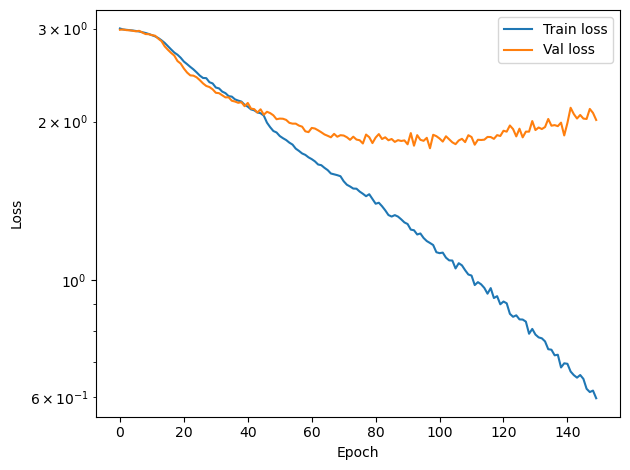

Loaded best model with val_loss=1.7795
Final Test: test_loss=2.0331, null_test_loss=2.9957
Saved model: s4_3_f00.pt
f=0.0, Test Accuracy: 36.33%


In [8]:
f_values = [0.0]

for f in f_values:
    print(f"\n### Training model for f = {f} ###")

    var_name = f"net_{int(f * 10):02d}" 
    net, val_loss = train_model(f=f, num_epochs=150)
    globals()[var_name] = net
    model_path = f"s4_3_f{int(f * 10):02d}.pt"
    torch.save(net.state_dict(), model_path)
    print(f"Saved model: {model_path}")
    acc = test_accuracy(net, testing_range, batch_size=128, f=f, device='cuda')
    print(f"f={f:.1f}, Test Accuracy: {acc:.2%}")


### Training model for f = 0.2 ###

=== Training model with f=0.2, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 3276), total 3276 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0107 GB


100%|██████████| 6000/6000 [32:37<00:00,  3.06it/s, epoch=149, null_val=3, train_loss=1.56, val_loss=1.67]


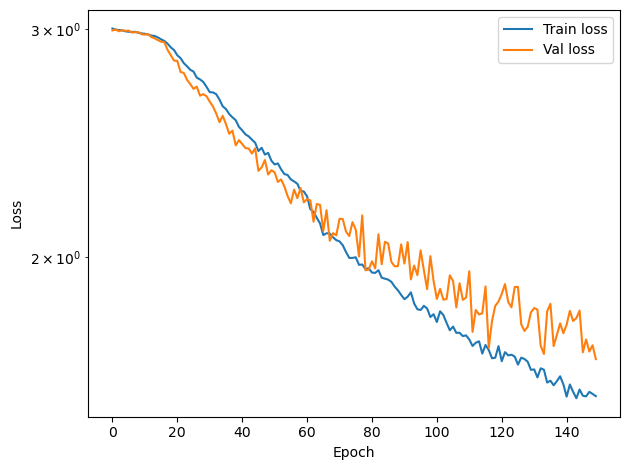

Loaded best model with val_loss=1.6690
Final Test: test_loss=1.8137, null_test_loss=2.9957
Saved model: s4_3_f02.pt
f=0.2, Test Accuracy: 38.02%

### Training model for f = 0.4 ###

=== Training model with f=0.4, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 3276), total 3276 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0107 GB


100%|██████████| 6000/6000 [34:37<00:00,  2.89it/s, epoch=149, null_val=3, train_loss=1.97, val_loss=2.04]


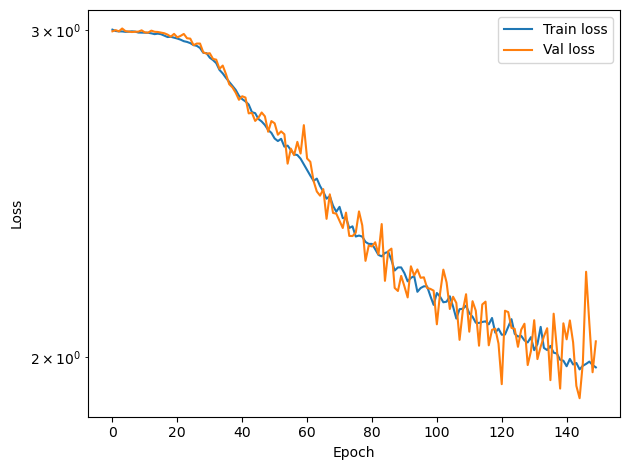

Loaded best model with val_loss=1.8997
Final Test: test_loss=2.0999, null_test_loss=2.9957
Saved model: s4_3_f04.pt
f=0.4, Test Accuracy: 30.47%

### Training model for f = 0.6 ###

=== Training model with f=0.6, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 3276), total 3276 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0107 GB


100%|██████████| 6000/6000 [36:20<00:00,  2.75it/s, epoch=149, null_val=3, train_loss=2.35, val_loss=2.42]


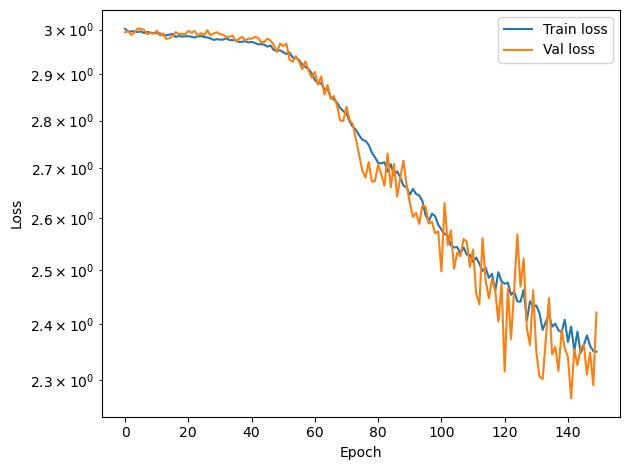

Loaded best model with val_loss=2.2681
Final Test: test_loss=2.4358, null_test_loss=2.9957
Saved model: s4_3_f06.pt
f=0.6, Test Accuracy: 22.79%

### Training model for f = 0.8 ###

=== Training model with f=0.8, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 3276), total 3276 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0107 GB


100%|██████████| 6000/6000 [38:11<00:00,  2.62it/s, epoch=149, null_val=3, train_loss=2.99, val_loss=3]   


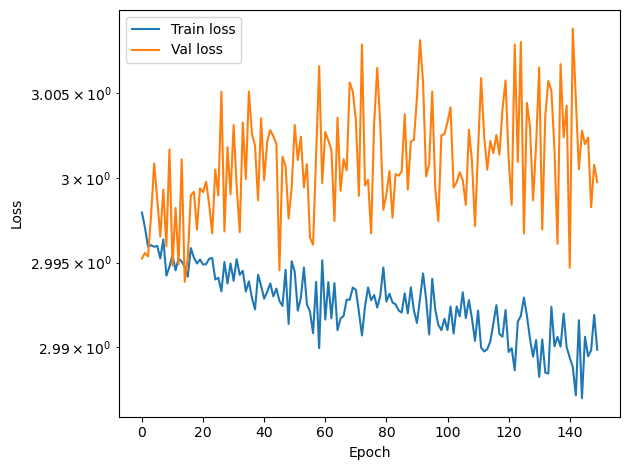

Loaded best model with val_loss=2.9939
Final Test: test_loss=2.9950, null_test_loss=2.9957
Saved model: s4_3_f08.pt
f=0.8, Test Accuracy: 4.30%

### Training model for f = 1.0 ###

=== Training model with f=1.0, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 3276), total 3276 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0107 GB


100%|██████████| 6000/6000 [40:08<00:00,  2.49it/s, epoch=149, null_val=3, train_loss=3, val_loss=3]   


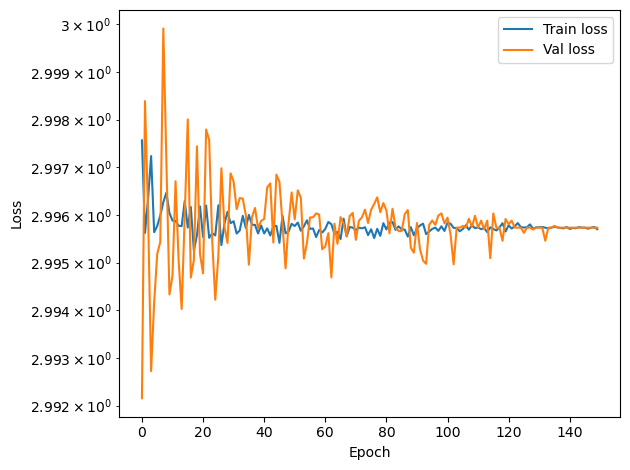

Loaded best model with val_loss=2.9922
Final Test: test_loss=2.9957, null_test_loss=2.9957
Saved model: s4_3_f10.pt
f=1.0, Test Accuracy: 6.25%


In [12]:
f_values = [0.2,0.4,0.6,0.8,1.0]

for f in f_values:
    print(f"\n### Training model for f = {f} ###")

    var_name = f"net_{int(f * 10):02d}" 
    net, val_loss = train_model(f=f, num_epochs=150)
    globals()[var_name] = net
    model_path = f"s4_3_f{int(f * 10):02d}.pt"
    torch.save(net.state_dict(), model_path)
    print(f"Saved model: {model_path}")
    acc = test_accuracy(net, testing_range, batch_size=128, f=f, device='cuda')
    print(f"f={f:.1f}, Test Accuracy: {acc:.2%}")


### Training model for f = 0.3 ###

=== Training model with f=0.3, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 3276), total 3276 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0107 GB


100%|██████████| 6000/6000 [33:41<00:00,  2.97it/s, epoch=149, null_val=3, train_loss=1.74, val_loss=1.89]


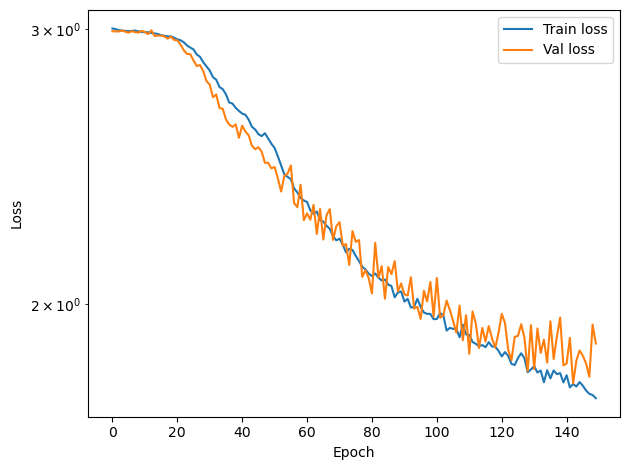

Loaded best model with val_loss=1.7802
Final Test: test_loss=2.0380, null_test_loss=2.9957
Saved model: s4_3_f03.pt
f=0.3, Test Accuracy: 35.81%

### Training model for f = 0.5 ###

=== Training model with f=0.5, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 3276), total 3276 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0107 GB


100%|██████████| 6000/6000 [35:39<00:00,  2.80it/s, epoch=149, null_val=3, train_loss=2.22, val_loss=2.34]


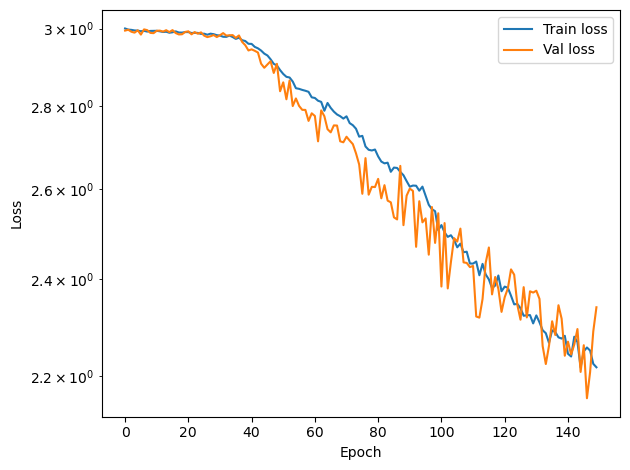

Loaded best model with val_loss=2.1577
Final Test: test_loss=2.3369, null_test_loss=2.9957
Saved model: s4_3_f05.pt
f=0.5, Test Accuracy: 25.13%

### Training model for f = 0.7 ###

=== Training model with f=0.7, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 3276), total 3276 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0107 GB


100%|██████████| 6000/6000 [37:40<00:00,  2.65it/s, epoch=149, null_val=3, train_loss=2.73, val_loss=2.71]


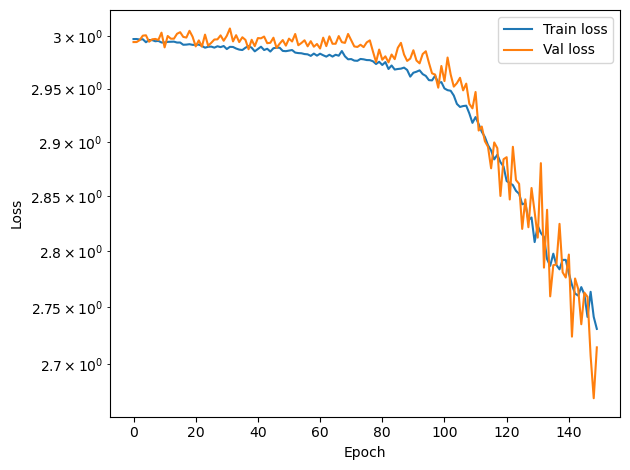

Loaded best model with val_loss=2.6705
Final Test: test_loss=2.7829, null_test_loss=2.9957
Saved model: s4_3_f07.pt
f=0.7, Test Accuracy: 14.84%

### Training model for f = 0.9 ###

=== Training model with f=0.9, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 3276), total 3276 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0107 GB


100%|██████████| 6000/6000 [39:32<00:00,  2.53it/s, epoch=149, null_val=3, train_loss=3, val_loss=3]   


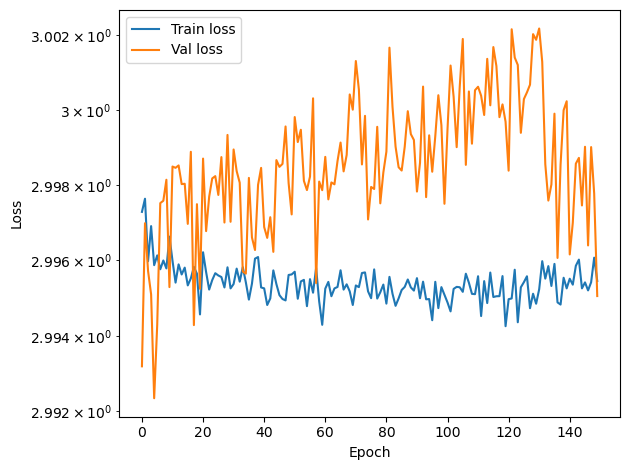

Loaded best model with val_loss=2.9923
Final Test: test_loss=2.9957, null_test_loss=2.9957
Saved model: s4_3_f09.pt
f=0.9, Test Accuracy: 5.86%


In [13]:
f_values = [0.3,0.5,0.7,0.9]

for f in f_values:
    print(f"\n### Training model for f = {f} ###")

    var_name = f"net_{int(f * 10):02d}" 
    net, val_loss = train_model(f=f, num_epochs=150)
    globals()[var_name] = net
    model_path = f"s4_3_f{int(f * 10):02d}.pt"
    torch.save(net.state_dict(), model_path)
    print(f"Saved model: {model_path}")
    acc = test_accuracy(net, testing_range, batch_size=128, f=f, device='cuda')
    print(f"f={f:.1f}, Test Accuracy: {acc:.2%}")


### Training model for f = 0.1 ###

=== Training model with f=0.1, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 3276), total 3276 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0107 GB


100%|██████████| 6000/6000 [32:57<00:00,  3.03it/s, epoch=149, null_val=3, train_loss=1.3, val_loss=1.76] 


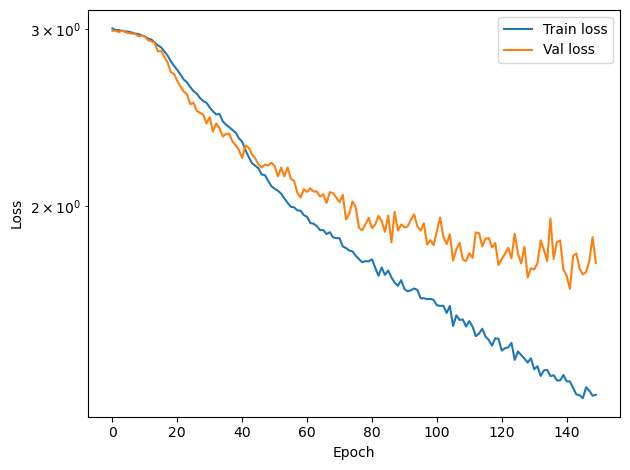

Loaded best model with val_loss=1.6561
Final Test: test_loss=1.6958, null_test_loss=2.9957
Saved model: s4_3_f01.pt
f=0.1, Test Accuracy: 36.98%

### Training model for f = 0.0 ###

=== Training model with f=0.0, num_epochs=150, seed=42 ===
Using device: cuda


  0%|          | 0/6000 [00:00<?, ?it/s]

Using data index range = [0, 3276), total 3276 samples
batch_size=64
num_time_points=100
num_batches=40
RAM usage per batch ~ 0.0107 GB


100%|██████████| 6000/6000 [33:33<00:00,  2.98it/s, epoch=149, null_val=3, train_loss=0.597, val_loss=2.01]


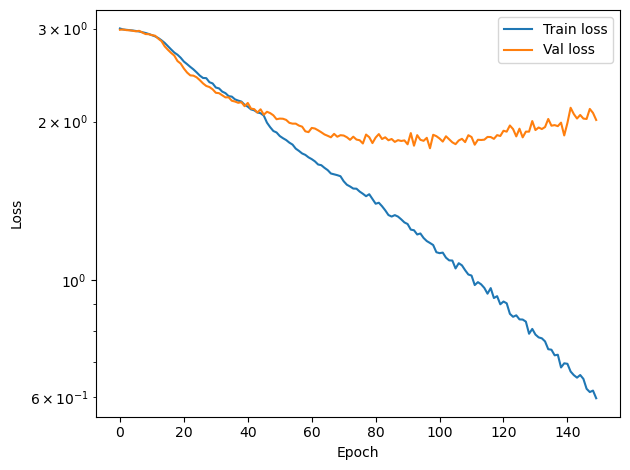

Loaded best model with val_loss=1.7795
Final Test: test_loss=2.0331, null_test_loss=2.9957
Saved model: s4_3_f00.pt
f=0.0, Test Accuracy: 36.33%


In [15]:
f_values = [0.1,0.0]

for f in f_values:
    print(f"\n### Training model for f = {f} ###")

    var_name = f"net_{int(f * 10):02d}" 
    net, val_loss = train_model(f=f, num_epochs=150)
    globals()[var_name] = net
    model_path = f"s4_3_f{int(f * 10):02d}.pt"
    torch.save(net.state_dict(), model_path)
    print(f"Saved model: {model_path}")
    acc = test_accuracy(net, testing_range, batch_size=128, f=f, device='cuda')
    print(f"f={f:.1f}, Test Accuracy: {acc:.2%}")

## Evaluation

Using device: cuda

=== Loading model s4_3_f00.pt and testing ===
f=0.0, Test Accuracy: 36.33%

=== Loading model s4_3_f01.pt and testing ===
f=0.1, Test Accuracy: 37.24%

=== Loading model s4_3_f02.pt and testing ===
f=0.2, Test Accuracy: 38.41%

=== Loading model s4_3_f03.pt and testing ===
f=0.3, Test Accuracy: 36.07%

=== Loading model s4_3_f04.pt and testing ===
f=0.4, Test Accuracy: 31.51%

=== Loading model s4_3_f05.pt and testing ===
f=0.5, Test Accuracy: 25.13%

=== Loading model s4_3_f06.pt and testing ===
f=0.6, Test Accuracy: 20.96%

=== Loading model s4_3_f07.pt and testing ===
f=0.7, Test Accuracy: 13.41%

=== Loading model s4_3_f08.pt and testing ===
f=0.8, Test Accuracy: 4.82%

=== Loading model s4_3_f09.pt and testing ===
f=0.9, Test Accuracy: 6.12%

=== Loading model s4_3_f10.pt and testing ===
f=1.0, Test Accuracy: 6.25%


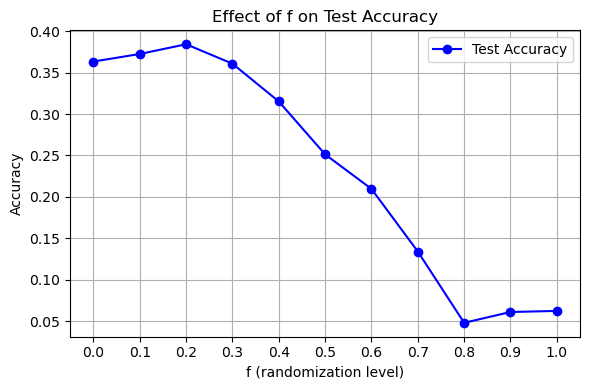

In [16]:
import torch
import matplotlib.pyplot as plt
from scipy import io

data = io.loadmat('spikedata4_3.mat')
X = data['X']  # (N, num_neurons, T)
Y = data['Y'].ravel()

f_values = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
accuracies = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

for f in f_values:
    model_path = f"s4_3_f{int(f*10):02d}.pt"
    print(f"\n=== Loading model {model_path} and testing ===")

    net = TutorialSNN(num_neurons, 200, num_classes)
    net.load_state_dict(torch.load(model_path, map_location=device))
    net.to(device)

    acc = test_accuracy(net, time_fractions=testing_range, batch_size=256, f=f, device=device)
    accuracies.append(acc)
    print(f"f={f:.1f}, Test Accuracy: {acc:.2%}")

plt.figure(figsize=(6, 4))
plt.plot(f_values, accuracies, marker='o', linestyle='-', color='b', label="Test Accuracy")
plt.xlabel("f (randomization level)")
plt.ylabel("Accuracy")
plt.title("Effect of f on Test Accuracy")
plt.xticks(f_values)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



=== Loading model s4_3_f00.pt and testing (f=0.0) ===
f=0.0, Mean Acc=36.33%, Std=0.00% (over 5 runs)

=== Loading model s4_3_f01.pt and testing (f=0.1) ===
f=0.1, Mean Acc=38.52%, Std=1.09% (over 5 runs)

=== Loading model s4_3_f02.pt and testing (f=0.2) ===
f=0.2, Mean Acc=37.97%, Std=0.64% (over 5 runs)

=== Loading model s4_3_f03.pt and testing (f=0.3) ===
f=0.3, Mean Acc=36.12%, Std=0.73% (over 5 runs)

=== Loading model s4_3_f04.pt and testing (f=0.4) ===
f=0.4, Mean Acc=31.93%, Std=0.44% (over 5 runs)

=== Loading model s4_3_f05.pt and testing (f=0.5) ===
f=0.5, Mean Acc=26.04%, Std=0.98% (over 5 runs)

=== Loading model s4_3_f06.pt and testing (f=0.6) ===
f=0.6, Mean Acc=21.33%, Std=1.23% (over 5 runs)

=== Loading model s4_3_f07.pt and testing (f=0.7) ===
f=0.7, Mean Acc=14.09%, Std=0.66% (over 5 runs)

=== Loading model s4_3_f08.pt and testing (f=0.8) ===
f=0.8, Mean Acc=4.64%, Std=0.24% (over 5 runs)

=== Loading model s4_3_f09.pt and testing (f=0.9) ===
f=0.9, Mean Acc=5.8

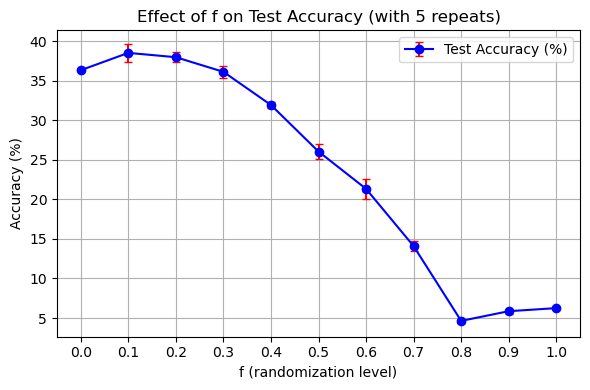

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import io

def test_accuracy_repeats(net, repeats=5, f=0.0):
    """
    在相同 f 值下, 测试 repeats 次 (若 test_accuracy 有随机因素, 重复测可产生波动)
    返回 长度为 repeats 的准确率列表
    """
    acc_list = []
    for r in range(repeats):
        # 如果测试过程有 seed 之类的, 可以在这里设定 torch.manual_seed(...) 
        # or np.random.seed(...) 以便每次略有不同

        acc = test_accuracy(net,
                            time_fractions=testing_range,
                            batch_size=256,
                            f=f,
                            device=device)
        acc_list.append(acc)
    return acc_list

all_means = []
all_stds = []

repeats = 5  # 例如跑5次

for f in f_values:
    model_path = f"s4_3_f{int(f*10):02d}.pt"
    print(f"\n=== Loading model {model_path} and testing (f={f}) ===")

    net = TutorialSNN(num_neurons, 200, num_classes)
    net.load_state_dict(torch.load(model_path, map_location=device))
    net.to(device)
    net.eval()

    # 多次测
    acc_list = test_accuracy_repeats(net, repeats=repeats, f=f)
    mean_acc = np.mean(acc_list)
    std_acc  = np.std(acc_list)

    all_means.append(mean_acc)
    all_stds.append(std_acc)

    print(f"f={f:.1f}, Mean Acc={mean_acc:.2%}, Std={std_acc:.2%} (over {repeats} runs)")


# -------------------
# 4) 绘制带误差棒的曲线
# -------------------
plt.figure(figsize=(6, 4))

# 将准确率转换成百分比或保持原小数也可以
means_pct = [m * 100 for m in all_means]
stds_pct  = [s * 100 for s in all_stds]

# 使用 errorbar 传入 yerr
plt.errorbar(f_values, means_pct, yerr=stds_pct,
             fmt='-o', color='b', ecolor='r', capsize=3,
             label='Test Accuracy (%)')

plt.xlabel("f (randomization level)")
plt.ylabel("Accuracy (%)")
plt.title(f"Effect of f on Test Accuracy (with {repeats} repeats)")
plt.xticks(f_values)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Mathematical Analysis

## 从梯度传播角度分析：SNN 的 sensitivity 是局部的：
surrogate gradient这本质上是一种 trick，使得 SNN 能像传统 ANN 一样反向传播。
你训练的是一个神经元电压积分的模型，例如：u[t+1] = αu[t] + wᵀx[t] - βs[t]，在 surrogate BP 中，你用一个 平滑函数 σ来近似 spike 的导数：∂L/∂x[t] ≈ ∂L/∂s[t] * σ′(u[t])
可分析点：
- 当输入 spike `x[t]` 出现在不同时间点（比如 t=20 vs t=80）时，梯度是否等价？
- surrogate 的梯度是否在 spike 发生前后区域“集中”？（局部 vs 全局）
- 你可以画出时间轴上每个输入时间点的 gradient ∂L/∂x[t] 的强度分布
意义：揭示 surrogate gradient 的时间局部性，从而解释模型为什么难以捕捉长距离时依赖或序列间“全局模式”。可以通过这个方法判断模型有没有用到长程的时间结构？surrogate SNN 的学习机制是不是太“近视”（只看局部）？

Epoch 10, loss=24.3477, final_u=0.0657
Epoch 20, loss=23.5729, final_u=0.1448
Epoch 30, loss=22.8143, final_u=0.2236


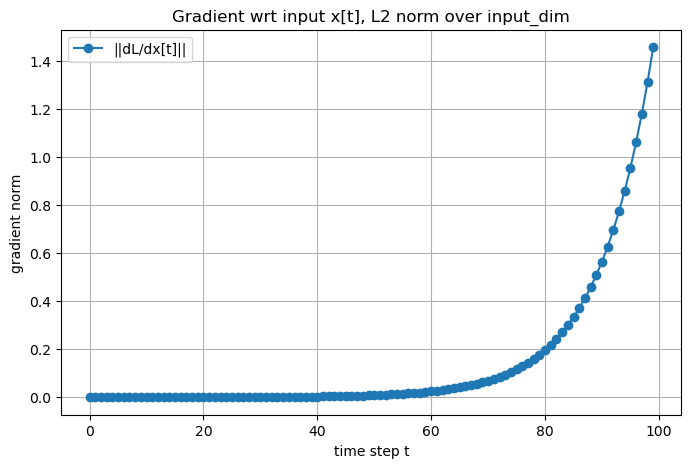

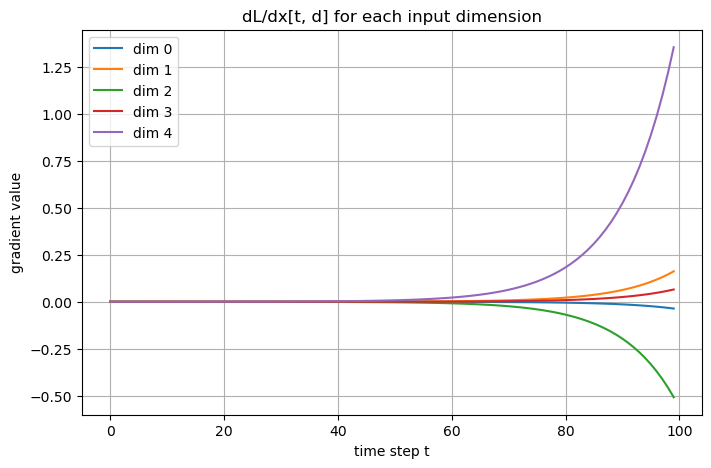

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# =============== 1) 定义 Surrogate Spiking 函数 ===============
# 这里采用最简单的近似: spike_fn = Heaviside(u-1),
# 其梯度用 (d/dU) ~ scale * sigmoid(...) 之类:
class SurrogateHeaviside(torch.autograd.Function):
    """
    Surrogate Heaviside spiking:
       forward: out = 1 if u>1 else 0
       backward: use a "fast sigmoid" or similar for gradient
    """
    scale = 100.0  # 越大则越近似于硬跳变

    @staticmethod
    def forward(ctx, input_u):
        ctx.save_for_backward(input_u)
        out = torch.zeros_like(input_u)
        out[input_u > 1.0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        (input_u,) = ctx.saved_tensors
        # 这里做一个简单近似 => grad ~= scale * sigmoid'(u-1)
        # 例: grad = scale * max(0, 1-|u-1|)
        # 或者使用更平滑: scale * (1/((1+|u-1|)^2)) etc.
        # 这里示例用 e^-|u-1|
        alpha = SurrogateHeaviside.scale
        diff = input_u - 1.0
        grad_input = grad_output * alpha * torch.exp(-alpha*diff.abs())
        return grad_input

# 简化写法: 
spike_fn = SurrogateHeaviside.apply


# =============== 2) 定义单神经元的 SNN 模型 ===============
class SingleNeuronSNN(nn.Module):
    """
    只有一个神经元:
      u[t+1] = alpha*u[t] + w^T x[t] - beta*s[t],
      s[t]   = spike_fn(u[t])
    """
    def __init__(self, input_dim, alpha=0.9, beta=0.9):
        super().__init__()
        self.input_dim = input_dim
        self.alpha = alpha
        self.beta  = beta

        # 只有1个神经元 => w维度 = (input_dim,)
        self.w = nn.Parameter(torch.randn(input_dim)*0.1)
        # 初值可以有bias => 这里示例不加 bias

    def forward(self, x, record=False):
        """
        x.shape = (batch_size, T, input_dim)
        return (u_rec, s_rec):
           u_rec.shape = (batch_size, T)
           s_rec.shape = (batch_size, T)
        """
        batch_size, T, _ = x.shape
        device = x.device

        # 记录
        u = torch.zeros((batch_size,), device=device)
        s = torch.zeros((batch_size,), device=device)

        u_rec = []
        s_rec = []

        for t in range(T):
            # 1) spike 
            s = spike_fn(u) 
            # 2) update membrane
            #    u_new = alpha*u + w^T x[t] - beta*s
            x_t = x[:, t, :]   # shape = (batch_size, input_dim)
            current = F.linear(x_t, self.w)  # batch_size
            u = self.alpha*u + current - self.beta*s

            # 保存
            u_rec.append(u)
            s_rec.append(s)

        u_rec = torch.stack(u_rec, dim=1) # (batch_size, T)
        s_rec = torch.stack(s_rec, dim=1) # (batch_size, T)
        return u_rec, s_rec

# =============== 3) 构造一个示例，用随机输入训练/分析 ===============
def example_training_and_gradient_plot():
    torch.manual_seed(42)
    np.random.seed(42)

    # 超参
    batch_size = 1      # 我们想可视化单条序列 => batch_size=1
    T = 100             # 时间长度
    input_dim = 5       # 每个时刻输入维度
    alpha, beta = 0.9, 0.9
    lr = 1e-3
    num_epochs = 30

    # 创建模型
    net = SingleNeuronSNN(input_dim, alpha, beta)

    # 构造一个随机输入, x.shape=(1, T, input_dim)
    # 你也可以换成更有意义的脉冲输入(0/1), 这里用随机值做示例
    x_seq = torch.randn((batch_size, T, input_dim), requires_grad=True)

    # 假设我们的目标: 希望最终时刻(或最后几步)的膜电位 u[T] 接近 5.0
    # 只是随便定义一个回归型的目标, 使得网络要学 w
    target_u = 5.0

    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        u_rec, s_rec = net(x_seq)   # (1, T)
        # 只关心最后时刻的膜电位 => 计算loss
        final_u = u_rec[:, -1]      # shape=(1,)
        loss = F.mse_loss(final_u, torch.tensor([target_u]))
        loss.backward()

        optimizer.step()

        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}, loss={loss.item():.4f}, final_u={final_u.item():.4f}")

    # ========== 训练完后, 我们想可视化 ∂L/∂x[t] ==========
    # PyTorch 里, x_seq 是 leaf=True, requires_grad=True
    # 但是在上面训练里, 我们每次都 zero_grad & backward => gradient被清空
    # => 所以需要再做一次 forward/backward, 读取 gradient
    net.eval()
    x_seq.grad = None   # 清空
    with torch.enable_grad():
        u_rec, s_rec = net(x_seq)
        final_u = u_rec[:, -1] 
        loss = F.mse_loss(final_u, torch.tensor([target_u]))
        loss.backward()

    # 现在 x_seq.grad.shape = (1, T, input_dim)
    # => ∂L/∂x[t,d]
    grad_x = x_seq.grad.detach().cpu().numpy().squeeze(0) # => shape=(T, input_dim)

    # 画图, 以时间轴 t=0..T-1 为横坐标, 纵坐标是 ||∂L/∂x[t]|| 或者逐维分开
    time_axis = np.arange(T)

    # (a) 先看 L2 范数
    grad_norm = np.linalg.norm(grad_x, axis=1)  # shape=(T,)
    plt.figure(figsize=(8, 5))
    plt.plot(time_axis, grad_norm, marker='o', label='||dL/dx[t]||')
    plt.xlabel("time step t")
    plt.ylabel("gradient norm")
    plt.title("Gradient wrt input x[t], L2 norm over input_dim")
    plt.grid(True)
    plt.legend()
    plt.show()

    # (b) 也可逐维画
    plt.figure(figsize=(8, 5))
    for d in range(input_dim):
        plt.plot(time_axis, grad_x[:, d], label=f"dim {d}")
    plt.xlabel("time step t")
    plt.ylabel("gradient value")
    plt.title("dL/dx[t, d] for each input dimension")
    plt.grid(True)
    plt.legend()
    plt.show()


if __name__ == "__main__":
    example_training_and_gradient_plot()


Loaded dataset: X=(5460,224,100), Y=(5460)
Loaded model from s4_3_f00.pt
Computed gradient wrt input, shape=(100, 224), sample_idx=0, label=7


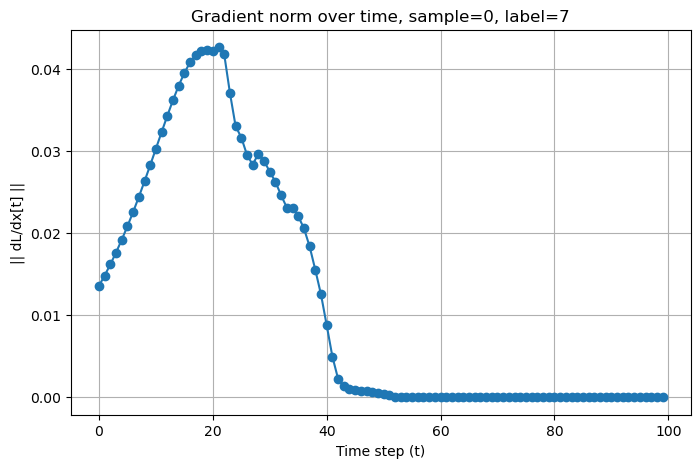

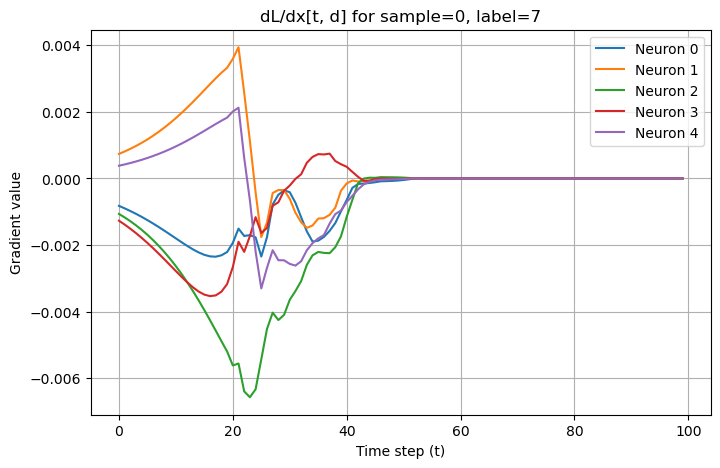

In [24]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy import io

# 假设你已有如下定义的网络模型:
# from your_snn_script import TutorialSNN, spike_fn, test_accuracy  # etc.
# 或者直接把 TutorialSNN 类的定义复制进来

# =========== 1) 读取数据, 模型, 并选取一个样本 ===========
data = io.loadmat("spikedata4_3.mat")
X_data = data["X"]  # shape: (N, num_neurons, T)
Y_data = data["Y"].ravel()
N, num_neurons, T = X_data.shape
print(f"Loaded dataset: X=({N},{num_neurons},{T}), Y=({len(Y_data)})")

# 载入你训练好的模型权重, e.g. s4_3_f00.pt
model_path = "s4_3_f00.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = TutorialSNN(nb_inputs=224, nb_hidden=200, nb_outputs=20).to(device)
net.load_state_dict(torch.load(model_path, map_location=device))
net.eval()
print(f"Loaded model from {model_path}")


# =========== 2) 选取一个样本进行梯度分析 ===========
sample_idx = 0  # 你想分析第几个样本
x_np = X_data[sample_idx]   # shape: (num_neurons, T)
label = Y_data[sample_idx]

# PyTorch 前向需要 batch 维, 以及 (batch_size, T, nb_inputs) 形式
# 但我们注意到 TutorialSNN forward 中若检测到 input.dim()==3, 就会 permute(0,2,1).
# 所以我们先构造 (1, T, num_neurons), 让它 permute 成 (1, num_neurons, T) 内部用.
# 如果 x_np.shape=(n_in, T), 先扩展batch维:
x_np_expanded = x_np[np.newaxis]  # => (1, n_in, T)
x_torch = torch.tensor(
    x_np_expanded,
    dtype=torch.float32,
    requires_grad=True,
    device=device
)


# 对应 label 也需要 batch 维
label_tensor = torch.tensor([label], dtype=torch.long, device=device)


# =========== 3) 前向传播, 取 cross-entropy 作为目标, 反向传播 ===========
with torch.enable_grad():
    out_rec, _ = net(x_torch)  # out_rec.shape=(1, T+1, nb_outputs)
    # 取 max-over-time => shape=(1, nb_outputs)
    m, _ = torch.max(out_rec, dim=1)
    # 对应 label 做 cross-entropy
    log_probs = F.log_softmax(m, dim=1).to(device)
    loss = F.nll_loss(log_probs, label_tensor)

# 清空之前的梯度, 再 backward
net.zero_grad()
if x_torch.grad is not None:
    x_torch.grad.zero_()
loss.backward()

# x_torch.grad.shape => (1, T, num_neurons)
grad_x = x_torch.grad.detach().cpu().numpy()[0]  # => shape (T, num_neurons)
grad_x = grad_x.T                                # => (100, 224)

print(f"Computed gradient wrt input, shape={grad_x.shape}, sample_idx={sample_idx}, label={label}")

# =========== 4) 画图: 梯度随时间步的分布 ===========
time_axis = np.arange(T)

# (a) 看各时间步梯度的 L2 范数
grad_norm = np.linalg.norm(grad_x, axis=1)  # => shape (T,)
plt.figure(figsize=(8,5))
plt.plot(time_axis, grad_norm, marker='o')
plt.title(f"Gradient norm over time, sample={sample_idx}, label={label}")
plt.xlabel("Time step (t)")
plt.ylabel("|| dL/dx[t] ||")
plt.grid(True)
plt.show()

# (b) 也可以画每个神经元维度, 但维度多了画面可能杂乱
# 这里演示画前几个维度
plt.figure(figsize=(8,5))
for d in range(min(5, num_neurons)):  # 只画前5个神经元
    plt.plot(time_axis, grad_x[:, d], label=f"Neuron {d}")

plt.title(f"dL/dx[t, d] for sample={sample_idx}, label={label}")
plt.xlabel("Time step (t)")
plt.ylabel("Gradient value")
plt.grid(True)
plt.legend()
plt.show()


Loaded dataset: X=(5460,224,100), Y=(5460)
Loaded model from s4_3_f00.pt


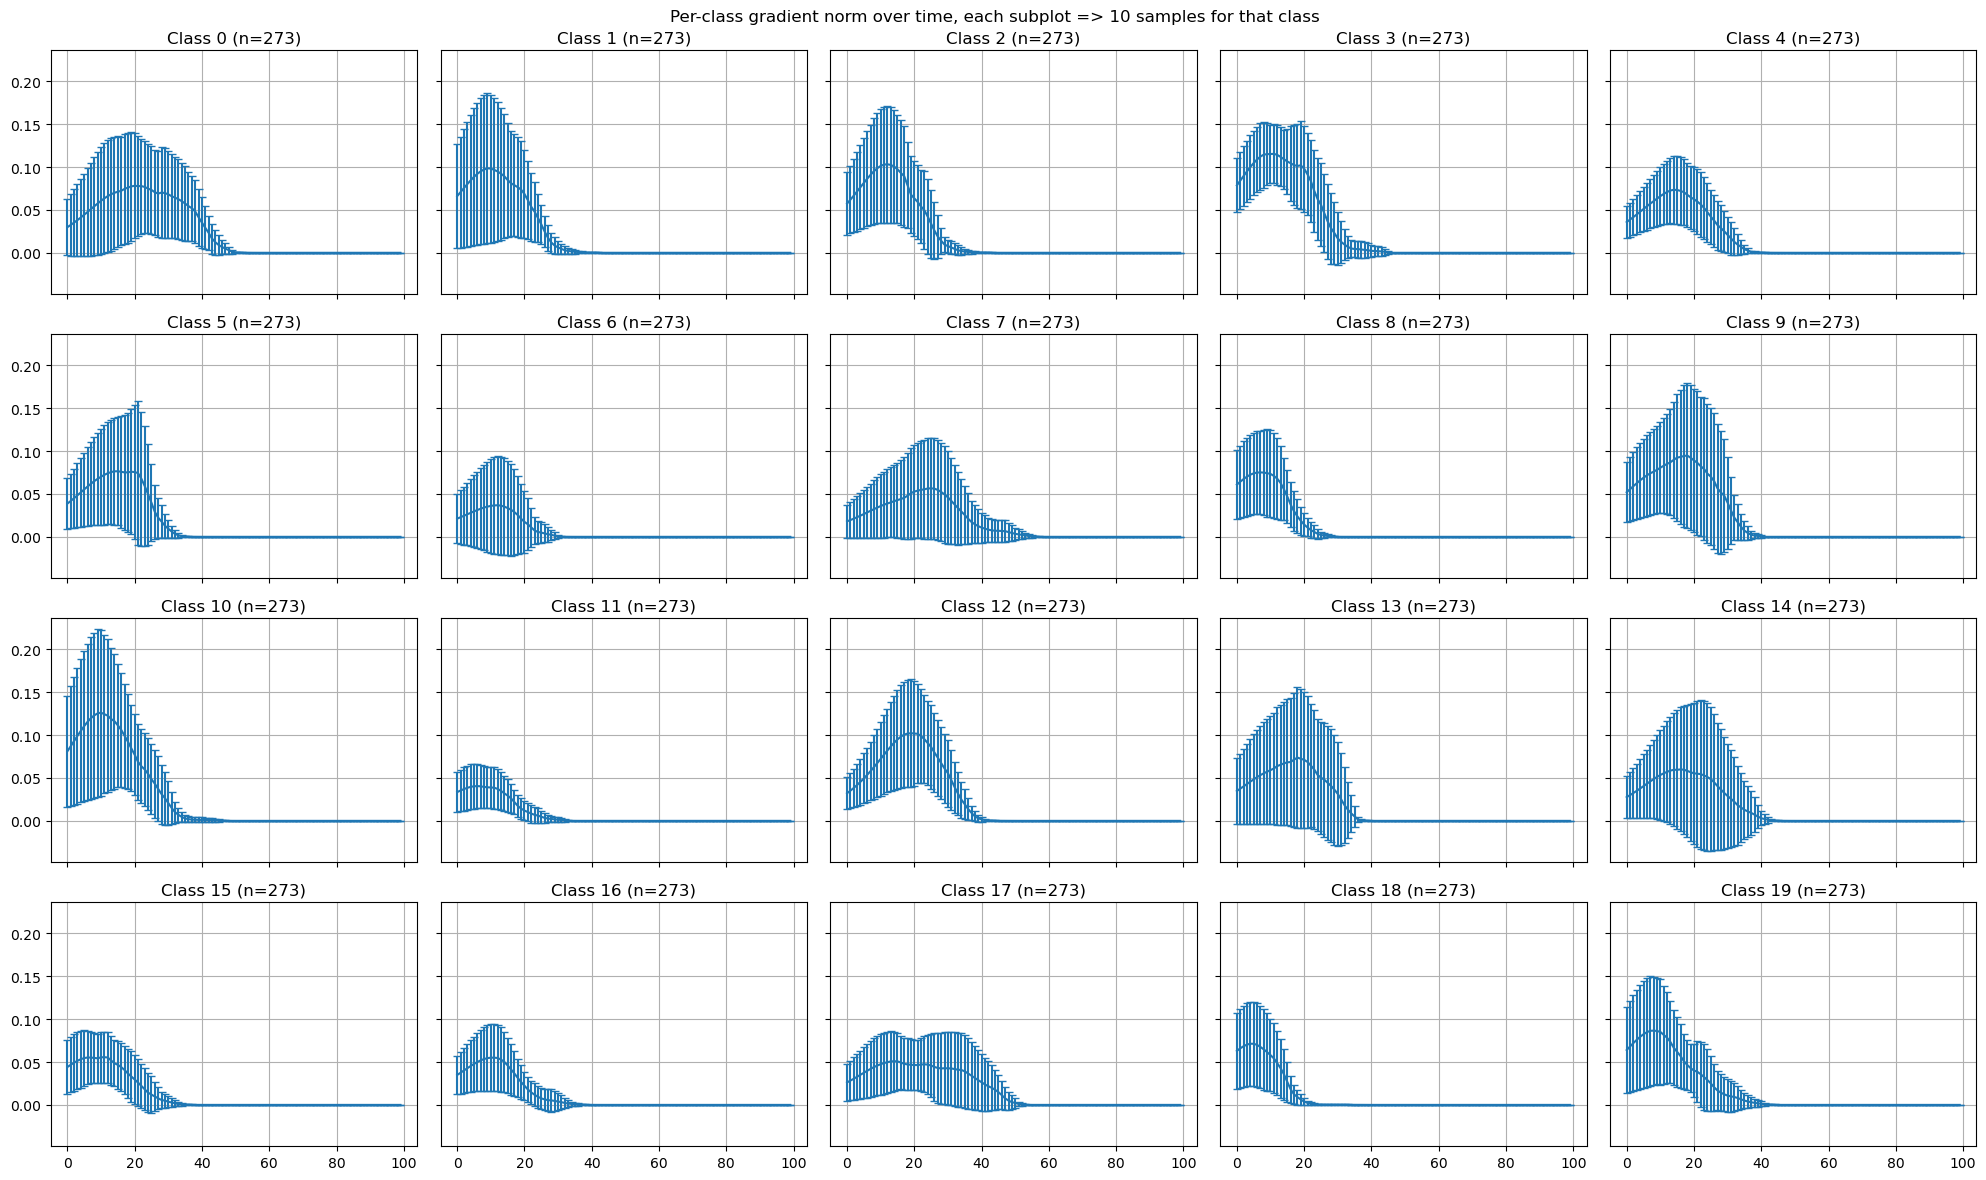

Samples per class: [273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273]


In [29]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy import io

###############################################################################
# 0) 你的模型定义 & TutorialSNN 类 & forward 等 (省略或从外部 import)
#    示例: net = TutorialSNN(nb_inputs, nb_hidden, nb_outputs)
###############################################################################

###############################################################################
# 1) 读取数据, 加载模型
###############################################################################
data = io.loadmat("spikedata4_3.mat")
X_data = data["X"]  # shape: (N, num_neurons, T)
Y_data = data["Y"].ravel()
N, num_neurons, T = X_data.shape
print(f"Loaded dataset: X=({N},{num_neurons},{T}), Y=({len(Y_data)})")

num_classes = 20  # 假设标签是0~19，共20类
model_path = "s4_3_f00.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 载入训练好的模型
net = TutorialSNN(nb_inputs=num_neurons, nb_hidden=200, nb_outputs=num_classes).to(device)
net.load_state_dict(torch.load(model_path, map_location=device))
net.eval()
print(f"Loaded model from {model_path}")

###############################################################################
# 2) 定义一个函数: 对“单条样本”做 forward+backward, 返回每个时间步的梯度范数
###############################################################################
def compute_grad_norm_for_sample(x_np, label, net):
    """
    输入:
      x_np: shape=(n_in, T)，单条样本的脉冲数据
      label: scalar, 该样本所属类别
      net:   已加载好权重的 TutorialSNN
    输出:
      grad_norm: shape=(T,) => 各时间步的梯度范数 (对 n_in 做 L2)
    """
    # (1, n_in, T)
    x_np_expanded = x_np[np.newaxis]  
    x_torch = torch.tensor(x_np_expanded, dtype=torch.float32,
                           requires_grad=True, device=device)

    label_tensor = torch.tensor([label], dtype=torch.long, device=device)

    # forward
    with torch.enable_grad():
        out_rec, _ = net(x_torch)  # out_rec.shape = (1, T+1, nb_outputs)
        # 取 max-over-time => shape=(1, nb_outputs)
        m, _ = torch.max(out_rec, dim=1)
        # 与 label 做 cross-entropy
        log_probs = F.log_softmax(m, dim=1).to(device)
        loss = F.nll_loss(log_probs, label_tensor)

    # backward
    net.zero_grad()
    if x_torch.grad is not None:
        x_torch.grad.zero_()
    loss.backward()

    # x_torch.grad => (1, n_in, T)
    grad_x = x_torch.grad.detach().cpu().numpy()[0]  # => shape (n_in, T)
    # 转置 => (T, n_in)，让第 0 维是时间步
    grad_x = grad_x.T

    # 对每个 time step, 计算 L2 范数
    grad_norm = np.linalg.norm(grad_x, axis=1)  # => shape (T,)
    return grad_norm

###############################################################################
# 3) 按类别取10个样本，统计平均曲线+标准差，分子图展示
###############################################################################
rows, cols = 4, 5  # 4×5=20个子图
fig, axes = plt.subplots(rows, cols, figsize=(20, 12), sharex=True, sharey=True)
axes = axes.flatten()
time_axis = np.arange(T)

all_class_count = []  # 记录每类实际包含样本数

for c in range(num_classes):
    ax = axes[c]
    idxs_c = np.where(Y_data == c)[0]
    n_c = len(idxs_c)
    all_class_count.append(n_c)

    if n_c < 10:
        # 该类样本不足10条
        ax.set_title(f"Class {c} (only {n_c})")
        ax.axis("off")
        continue

    # 随机取10个
    np.random.shuffle(idxs_c)
    pick_samples = idxs_c[:10]

    # 计算梯度norm
    grad_norm_list = []
    for idx in pick_samples:
        x_np = X_data[idx]  # shape=(n_in, T)
        label = Y_data[idx]
        grad_norm = compute_grad_norm_for_sample(x_np, label, net)
        grad_norm_list.append(grad_norm)

    grad_norm_array = np.array(grad_norm_list)  # shape=(10, T)
    mean_vals = grad_norm_array.mean(axis=0)  # (T,)
    std_vals  = grad_norm_array.std(axis=0)   # (T,)

    # 绘制误差棒
    ax.errorbar(time_axis, mean_vals, yerr=std_vals, capsize=3)
    ax.set_title(f"Class {c} (n={n_c})")
    ax.grid(True)

# 对剩余多余子图(如果有)隐藏
for c in range(num_classes, rows*cols):
    axes[c].axis("off")

plt.suptitle("Per-class gradient norm over time, each subplot => 10 samples for that class")
plt.tight_layout()
plt.show()

# 可查看所有类别的样本数:
print("Samples per class:", all_class_count)


In [52]:
class NewSNN(nn.Module):
    def __init__(self,nb_inputs=224,nb_hidden=200,nb_outputs=20,time_step=1e-3,
                 tau_mem=10e-3,tau_syn=5e-3,weight_scale=0.2,device='cpu'):
        """
        w1, w2, v1 都用 normal_(..., std=weight_scale/sqrt(...))
        alpha, beta = exp(-dt/tau_syn), exp(-dt/tau_mem)
        """
        super().__init__()

        self.nb_inputs  = nb_inputs
        self.nb_hidden  = nb_hidden
        self.nb_outputs = nb_outputs
        self.time_step  = time_step
        self.tau_mem    = tau_mem
        self.tau_syn    = tau_syn
        self.device_str = device

        # w1 => (n_in, n_hidden)
        self.w1 = nn.Parameter(torch.empty((nb_inputs, nb_hidden), dtype=torch.float))
        # v1 => (n_hidden, n_hidden)
        self.v1 = nn.Parameter(torch.empty((nb_hidden, nb_hidden), dtype=torch.float))
        # w2 => (n_hidden, n_outputs)
        self.w2 = nn.Parameter(torch.empty((nb_hidden, nb_outputs), dtype=torch.float))

        # init
        torch.nn.init.normal_(self.w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))
        torch.nn.init.normal_(self.w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))
        torch.nn.init.normal_(self.v1, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

        # alpha, beta
        self.alpha = float(np.exp(-time_step / tau_syn))
        self.beta  = float(np.exp(-time_step / tau_mem))

    def forward(self, inputs, dtype=torch.float32):
        """
        inputs shape = (batch_size, nb_steps, nb_inputs)
        h1_from_input = einsum('abc,cd->abd',(inputs, w1))
        Finally return out_rec, [mem_rec, spk_rec]
        """
        if inputs.dim() == 3:
            inputs = inputs.permute(0, 2, 1)  # (B, T, input_size)

        device = torch.device(self.device_str if torch.cuda.is_available() else 'cpu')
        inputs = inputs.to(device=device, dtype=dtype)
        batch_size, nb_steps, _ = inputs.shape 

        # hidden states
        syn = torch.zeros((batch_size, self.nb_hidden), device=device, dtype=dtype)
        mem = torch.zeros((batch_size, self.nb_hidden), device=device, dtype=dtype)
        out = torch.zeros((batch_size, self.nb_hidden), device=device, dtype=dtype)

        mem_rec = []
        spk_rec = []

        # 1) Calculate input->hidden
        # inputs shape => (B,T,n_in) w1 => (n_in,n_hidden) => result => (B,T,n_hidden)
        h1_from_input = torch.einsum("abc,cd->abd", (inputs, self.w1.to(inputs.device)))

        # 2) nb_steps
        for t in range(nb_steps):
            # recurrent: out =>(B,n_hidden), v1=>(n_hidden,n_hidden) => shape(B,n_hidden)
            rec_input = torch.einsum("ab,bc->ac", (out, self.v1.to(inputs.device)))
            h1 = h1_from_input[:, t, :] + rec_input

            # mem-1 => spike
            mthr = mem - 1.0
            out_new = spike_fn(mthr)
            rst = out_new.detach()  # not backprop

            # new_syn= alpha*syn + h1
            # new_mem= (beta*mem + syn)*(1.0 - rst)
            new_syn = self.alpha*syn + h1
            new_mem = (self.beta*mem + syn)*(1.0 - rst)
            mem_rec.append(mem)
            spk_rec.append(out_new)
            mem = new_mem
            syn = new_syn
            out = out_new

        mem_rec = torch.stack(mem_rec, dim=1)
        spk_rec = torch.stack(spk_rec, dim=1)

        # 3) readout layer
        #  spk_rec => shape(B, nb_steps, n_hidden)
        h2 = torch.einsum("abc,cd->abd", (spk_rec, self.w2.to(inputs.device)))

        # flt, out =>(B, nb_outputs)
        flt = torch.zeros((batch_size, self.nb_outputs), device=device, dtype=dtype)
        out_read = torch.zeros((batch_size, self.nb_outputs), device=device, dtype=dtype)
        out_rec = [out_read]

        for t in range(nb_steps):
            new_flt = self.alpha*flt + h2[:, t, :]
            new_out = self.beta*out_read + flt
            flt = new_flt
            out_read = new_out
            out_rec.append(out_read)

        # =>(nb_steps+1, B, nb_outputs)->(B, nb_steps+1, nb_outputs)
        out_rec = torch.stack(out_rec, dim=1)
        other_recs = [mem_rec, spk_rec]
        return out_rec, other_recs

Constructed custom dataset: X=(20,224,100), Y=(20)


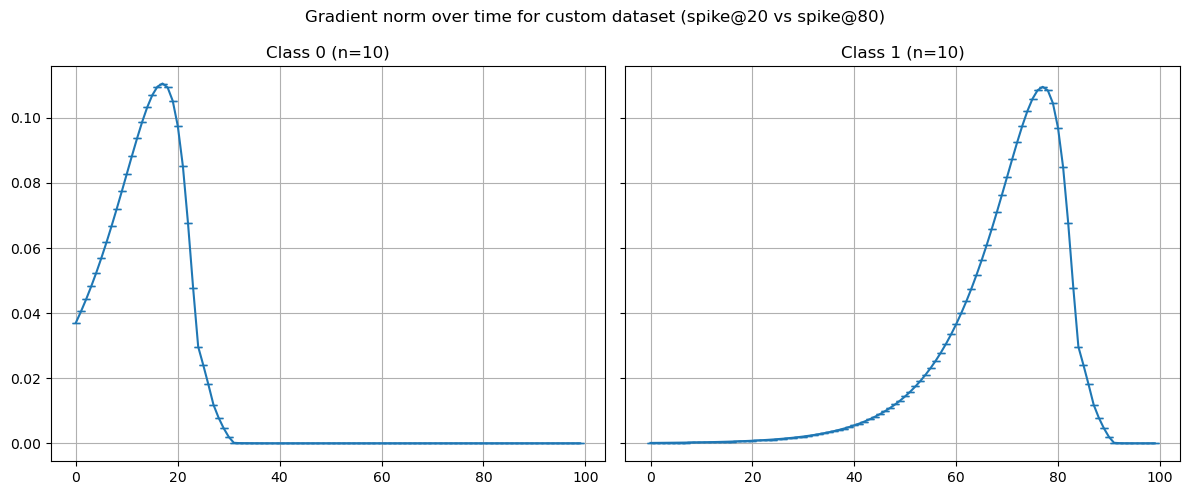

In [57]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

###############################################################################
# 0) 载入你原有的网络定义 & TutorialSNN 类 & forward 等
#    比如:
# from my_snn_script import TutorialSNN
###############################################################################

# =========== 1) 设置模型超参，加载预训练模型 ===========
num_neurons = 224        # 输入维度=224
T = 100                  # 时间步
num_classes = 20         # 如果你的模型实际上是20类，就写20
model_path = "s4_3_f00.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 载入训练好的模型
# net = TutorialSNN(nb_inputs=num_neurons, nb_hidden=200, nb_outputs=num_classes).to(device)
# net.load_state_dict(torch.load(model_path, map_location=device))
# net.eval()
# print(f"Loaded model from {model_path}")

###############################################################################
# 2) 手动构造一个“小型数据集” X_data, Y_data，形状=(N, num_neurons, T)
#    例如: N=20, 第0类 => spike 出现在 t=20，第1类 => spike 出现在 t=80
###############################################################################
N = 20
X_data = np.zeros((N, num_neurons, T), dtype=np.float32)
Y_data = np.zeros((N,), dtype=np.int32)  # 用 0/1 标记两类

# 前10个样本 => class 0 => spike@t=20
for i in range(10):
    X_data[i, :, 20] = 1.0  # 所有神经元在 t=20 spike
    Y_data[i] = 0

# 后10个样本 => class 1 => spike@t=80
for i in range(10, 20):
    X_data[i, :, 80] = 1.0  # 所有神经元在 t=80 spike
    Y_data[i] = 1

print(f"Constructed custom dataset: X=({N},{num_neurons},{T}), Y=({len(Y_data)})")

###############################################################################
# 3) 定义一个函数: 对“单条样本”做 forward+backward, 返回每个时间步的梯度范数
###############################################################################
def compute_grad_norm_for_sample(x_np, label, net):
    """
    x_np: shape=(num_neurons, T)
    label: 整数类别
    net:   已加载好权重的网络
    返回: grad_norm.shape=(T,) => 各时间步梯度范数
    """
    # (1, num_neurons, T)
    x_np_expanded = x_np[np.newaxis]
    x_torch = torch.tensor(x_np_expanded, dtype=torch.float32,
                           requires_grad=True, device=device)
    label_tensor = torch.tensor([label], dtype=torch.long, device=device)

    # forward
    with torch.enable_grad():
        out_rec, _ = net(x_torch)  # out_rec.shape=(1, T+1, num_classes)

        # ============== 关键修改：去掉最后那一维度 ==============
        # 这样 out_rec 变成 (1, T, num_classes)，与输入 T 一致
        out_rec = out_rec[:, :-1, :]

        # 然后做 max-over-time => shape=(1, num_classes)
        m, _ = torch.max(out_rec, dim=1)

        log_probs = F.log_softmax(m, dim=1).to(device)
        loss = F.nll_loss(log_probs, label_tensor)

    # backward
    net.zero_grad()
    if x_torch.grad is not None:
        x_torch.grad.zero_()
    loss.backward()

    # x_torch.grad => (1, num_neurons, T)
    grad_x = x_torch.grad.detach().cpu().numpy()[0]  # => shape (num_neurons, T)

    # 转置 => shape (T, num_neurons)，把时间放在前维
    grad_x = grad_x.T

    # 逐时间步做 L2 范数
    grad_norm = np.linalg.norm(grad_x, axis=1)  # => (T,)
    return grad_norm

###############################################################################
# 4) 每类取一些样本(这里两类各10个), 统计梯度分布
###############################################################################
import math

num_classes_for_plot = 2  # 这里只做2类: 0/1
rows, cols = 1, num_classes_for_plot  # 每类一个子图
fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5), sharex=True, sharey=True)

if num_classes_for_plot == 1:
    axes = [axes]

time_axis = np.arange(T)

for c in range(num_classes_for_plot):
    ax = axes[c] if num_classes_for_plot>1 else axes[0]
    idxs_c = np.where(Y_data == c)[0]
    n_c = len(idxs_c)

    grad_norm_list = []
    for idx in idxs_c:
        x_np = X_data[idx]
        label = Y_data[idx]
        grad_norm = compute_grad_norm_for_sample(x_np, label, net)
        grad_norm_list.append(grad_norm)

    grad_norm_array = np.array(grad_norm_list)  # shape=(n_c, T)
    mean_vals = grad_norm_array.mean(axis=0)
    std_vals  = grad_norm_array.std(axis=0)

    ax.errorbar(time_axis, mean_vals, yerr=std_vals, capsize=3)
    ax.set_title(f"Class {c} (n={n_c})")
    ax.grid(True)

plt.suptitle("Gradient norm over time for custom dataset (spike@20 vs spike@80)")
plt.tight_layout()
plt.show()


## 从输入扰动 vs 输出变化角度分析：定义 spike sensitivity
尝试构造一个“timing sensitivity score”，类似导数概念：
S(t) = \frac{||f(x) - f(x_{t+Δ})||}{Δ}
- `x` 是原始 spike train，`x_{t+Δ}` 表示把 spike 的某个时间点延迟 Δ ms
- `f(x)` 是模型输出（logits 或 softmax）
可以分析：
- SNN 对 spike 延迟的响应是线性变化？非线性？在哪些时间段更敏感？
- 在不同 `f` 值下 S(t) 平均值下降多少？
意义：定量分析模型对 spike 时间扰动的鲁棒性，与实验曲线形成呼应。
找出模型学习的关键时间区域	哪些时间段的 spike 是决策关键？（可以做注意力分析）
 解释 f 或 λ 增加时准确率下降	模型失去了对关键信息的捕捉能力，S(t) 曲线变平滑

Loaded dataset: X=(5460,224,100), Y=(5460)


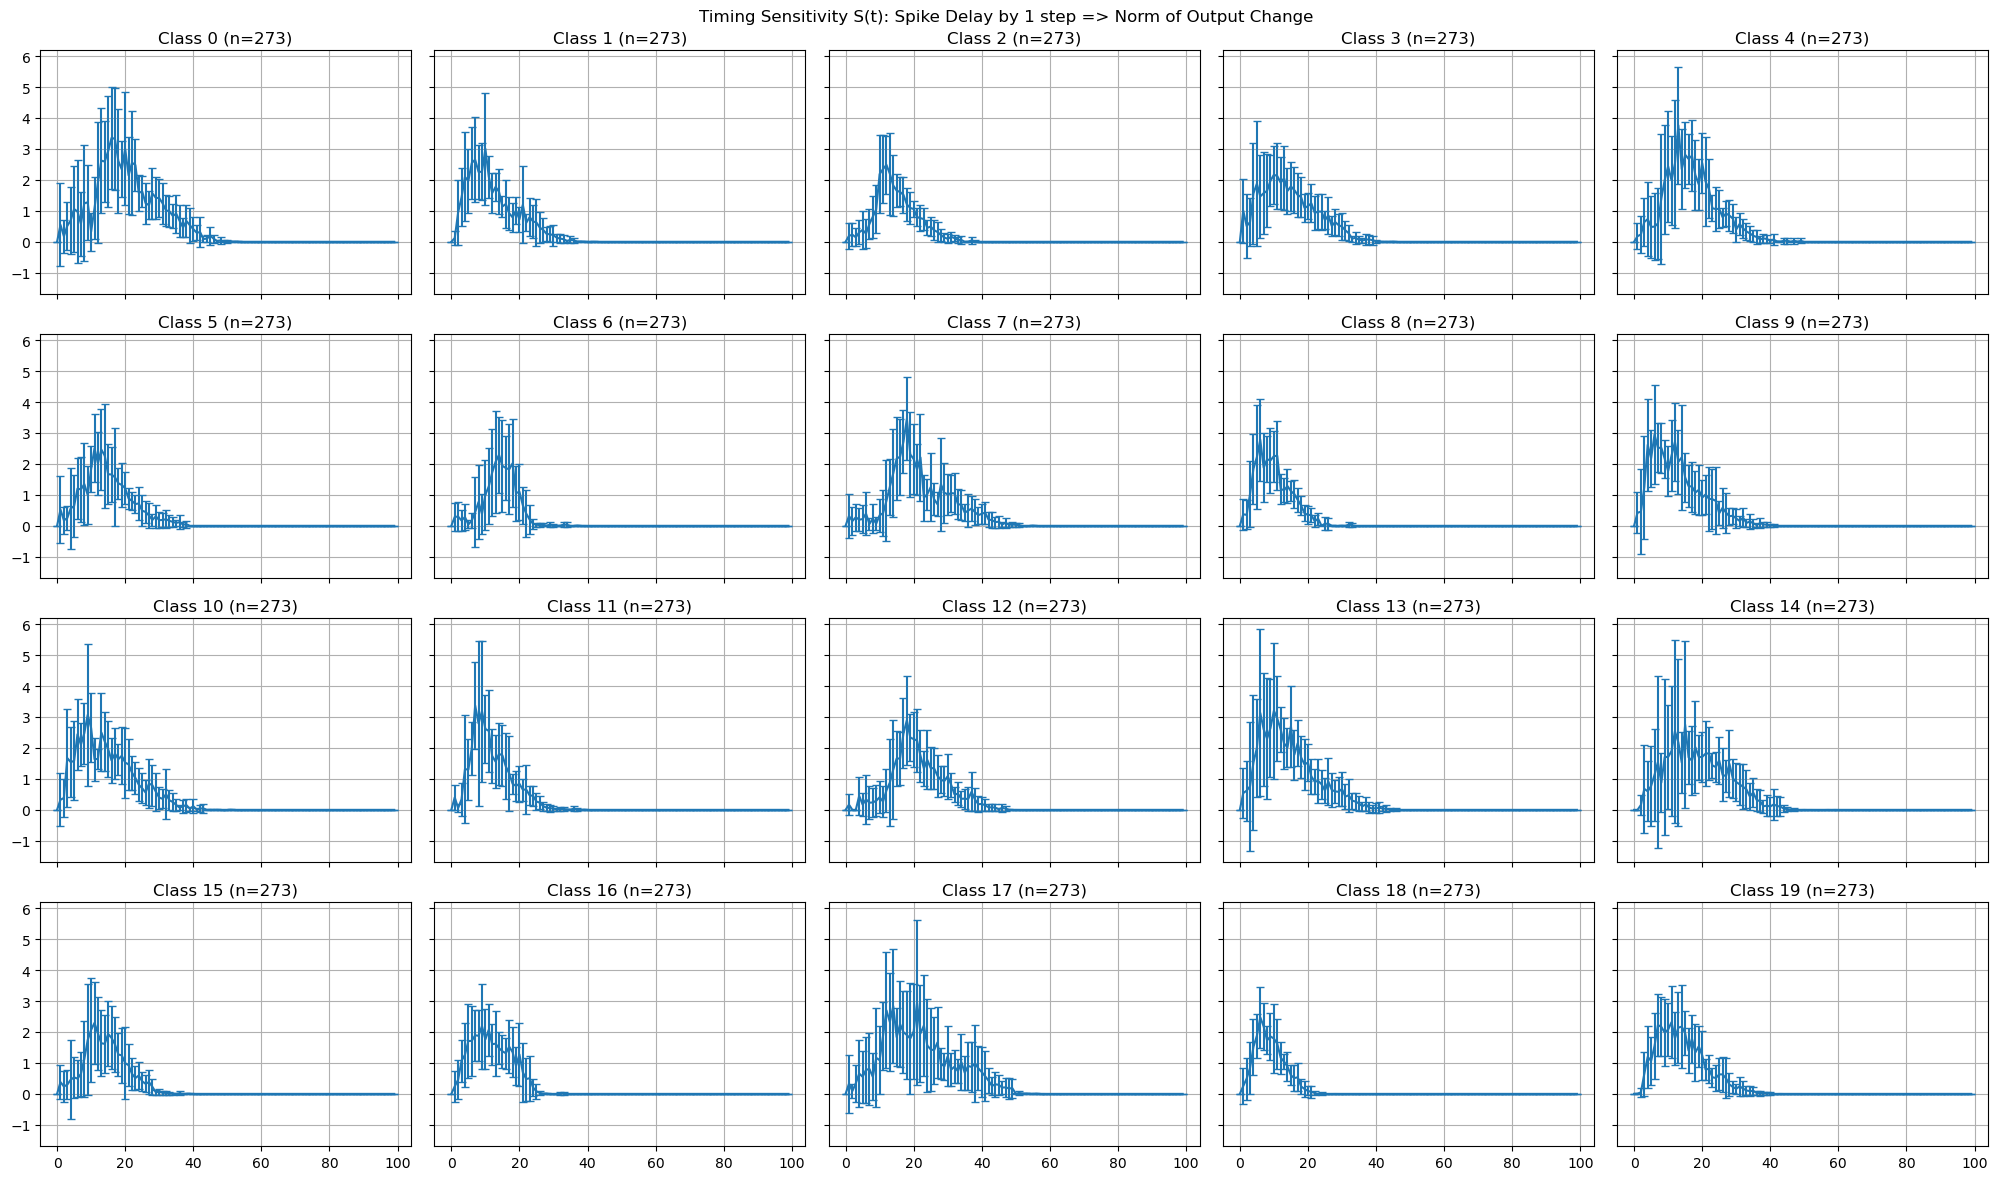

In [58]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy import io

###############################################################################
# 0) 你的模型定义 & TutorialSNN 类 & forward 等 (省略或从外部 import)
#    比如: from your_script import TutorialSNN
###############################################################################

###############################################################################
# 1) 读取数据, 加载模型
###############################################################################
data = io.loadmat("spikedata4_3.mat")
X_data = data["X"]  # shape: (N, num_neurons, T)
Y_data = data["Y"].ravel()
N, num_neurons, T = X_data.shape
print(f"Loaded dataset: X=({N},{num_neurons},{T}), Y=({len(Y_data)})")

num_classes = 20  
model_path = "s4_3_f00.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# net = TutorialSNN(nb_inputs=num_neurons, nb_hidden=200, nb_outputs=num_classes).to(device)
# net.load_state_dict(torch.load(model_path, map_location=device))
# net.eval()
# print(f"Loaded model from {model_path}")

###############################################################################
# 2) 定义一个函数: 计算 timing sensitivity => S(t)
###############################################################################
def compute_timing_sensitivity_for_sample(x_np, label, net, delta=1):
    """
    x_np: shape=(num_neurons, T)
    label: scalar, 该样本所属类别
    net:   已加载好权重的 SNN
    delta: spike 要向后挪动多少个 time step, 默认为1

    返回:
      s_t: shape=(T,), 记录对每个 t 的 sensitivity 分值
           s_t=|| f(x) - f(x_{t->t+delta}) || / delta
           若 x 在 t 没有 spike, s_t=0 (或可跳过)
    """
    # ============ 1) baseline output f(x) ============
    x_base = torch.tensor(x_np[np.newaxis],
                          dtype=torch.float32, device=device)
    with torch.no_grad():
        out_rec, _ = net(x_base)
        # 若 out_rec.shape=(1, T+1, nb_outputs), 则去掉末尾:
        out_rec = out_rec[:, :-1, :]
        # 取 max-over-time => shape=(1, nb_outputs)
        m, _ = torch.max(out_rec, dim=1)
        base_out = F.log_softmax(m, dim=1)  # shape=(1, nb_outputs)

    base_out_np = base_out.cpu().numpy().squeeze(0)  # => (nb_outputs,)
    # baseline logit or log-prob, 你也可用 net output raw logits

    # ============ 2) 遍历各个 t, 若 x[t]有 spike, 就挪到 t+delta 试试 ============
    s_t = np.zeros((T,), dtype=np.float32)

    for t in range(T):
        # 检查 x_np 在 t 处是否有 spike (对所有神经元?), 这里简单只看 sum
        # 你也可只移动特定 neuron
        if x_np[:, t].sum() < 0.5:
            # 说明这一时刻没 spike, 令 s_t=0
            continue

        # 构造一个副本
        x_shift = x_np.copy()
        # 把 t 时刻 spike 清零
        x_shift[:, t] = 0
        # 计算目标位置 t+delta
        new_t = t + delta
        if new_t >= T:
            # 超出范围 => 不计算 or s_t=0
            continue
        # 把 spike 挪到 new_t
        # 这里把 sum(x[:,t])都移到 x[:, new_t], 也可保留按 neuron dimension
        sum_spike = x_np[:, t]
        x_shift[:, new_t] += sum_spike

        # forward
        x_shift_torch = torch.tensor(x_shift[np.newaxis],
                                     dtype=torch.float32, device=device)
        with torch.no_grad():
            out_rec_shift, _ = net(x_shift_torch)
            # 如果 out_rec_shape=(1, T+1, nb_outputs), 去掉末尾
            out_rec_shift = out_rec_shift[:, :-1, :]
            m2, _ = torch.max(out_rec_shift, dim=1)
            out_shift = F.log_softmax(m2, dim=1)  # shape=(1, nb_outputs)
        out_shift_np = out_shift.cpu().numpy().squeeze(0)  # =>(nb_outputs,)

        diff = out_shift_np - base_out_np  # =>(nb_outputs,)
        diff_norm = np.linalg.norm(diff)   # => scalar

        # S(t) = ||f(x) - f(x_{t->t+delta})|| / delta
        s_t[t] = diff_norm / delta

    return s_t

###############################################################################
# 3) 做可视化: 按类别选10个样本 => average S(t)
###############################################################################
rows, cols = 4, 5  # 20类 => 4×5子图
fig, axes = plt.subplots(rows, cols, figsize=(20, 12), sharex=True, sharey=True)
axes = axes.flatten()
time_axis = np.arange(T)

for c in range(num_classes):
    ax = axes[c]
    idxs_c = np.where(Y_data == c)[0]
    n_c = len(idxs_c)

    if n_c < 10:
        ax.set_title(f"Class {c} (only {n_c})")
        ax.axis("off")
        continue

    np.random.shuffle(idxs_c)
    pick_samples = idxs_c[:10]

    s_t_list = []
    for idx in pick_samples:
        x_np = X_data[idx]  # shape=(n_in, T)
        label = Y_data[idx]
        # compute timing sensitivity
        s_t = compute_timing_sensitivity_for_sample(x_np, label, net, delta=1)
        s_t_list.append(s_t)

    s_t_array = np.array(s_t_list)  # (10, T)
    mean_vals = s_t_array.mean(axis=0)
    std_vals  = s_t_array.std(axis=0)

    ax.errorbar(time_axis, mean_vals, yerr=std_vals, capsize=3)
    ax.set_title(f"Class {c} (n={n_c})")
    ax.grid(True)

for c in range(num_classes, rows*cols):
    axes[c].axis("off")

plt.suptitle("Timing Sensitivity S(t): Spike Delay by 1 step => Norm of Output Change")
plt.tight_layout()
plt.show()


整体上，这些图显示：对于大部分类别，模型的判别对前 20～30 个 time steps 里的 spike 非常敏感，超过这个时间窗后灵敏度快速衰减。这说明在训练中，网络主要依赖那些早期出现的脉冲信息进行分类，而后期脉冲对最终决策影响很小。也从侧面表明SNN 的时序学习存在相对局部性，对于不在关键窗内的 spike，扰动其时序几乎不会改变网络输出。

## 从信息熵角度分析 spike train 中的信息量
把 spike train 视为离散事件序列，在每个神经元上计算 firing pattern 的分布，然后计算熵：
H = -\sum_{t} p_t \log p_t
比较：
  - 原始编码（f=0） vs 扰动编码（f=0.5 or 1.0）
  - 每个类别的平均熵是否不同？surrogate SNN 的权重是否更集中于低熵部分？
意义：从信息理论视角理解 SNN 更喜欢什么样的 spike 输入（structured vs noisy）
f 越大熵越高 → 准确率越低	timing structure 被破坏 → 输入变得更随机
类别之间熵有差异	可解释 class A 比 C 更好学，是因为 spike 更集中
模型偏好低熵输入	SNN 倾向利用 structured 信息，而不是 noisy spike

Loaded dataset: X=(5460,224,100), Y=(5460)
Unique classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]

=== Analyzing f=0.0 ===

=== Analyzing f=0.5 ===

=== Analyzing f=1.0 ===
class_counts: [273 273 273 273 273 273 273 273 273 273 273 273 273 273 273 273 273 273
 273 273]


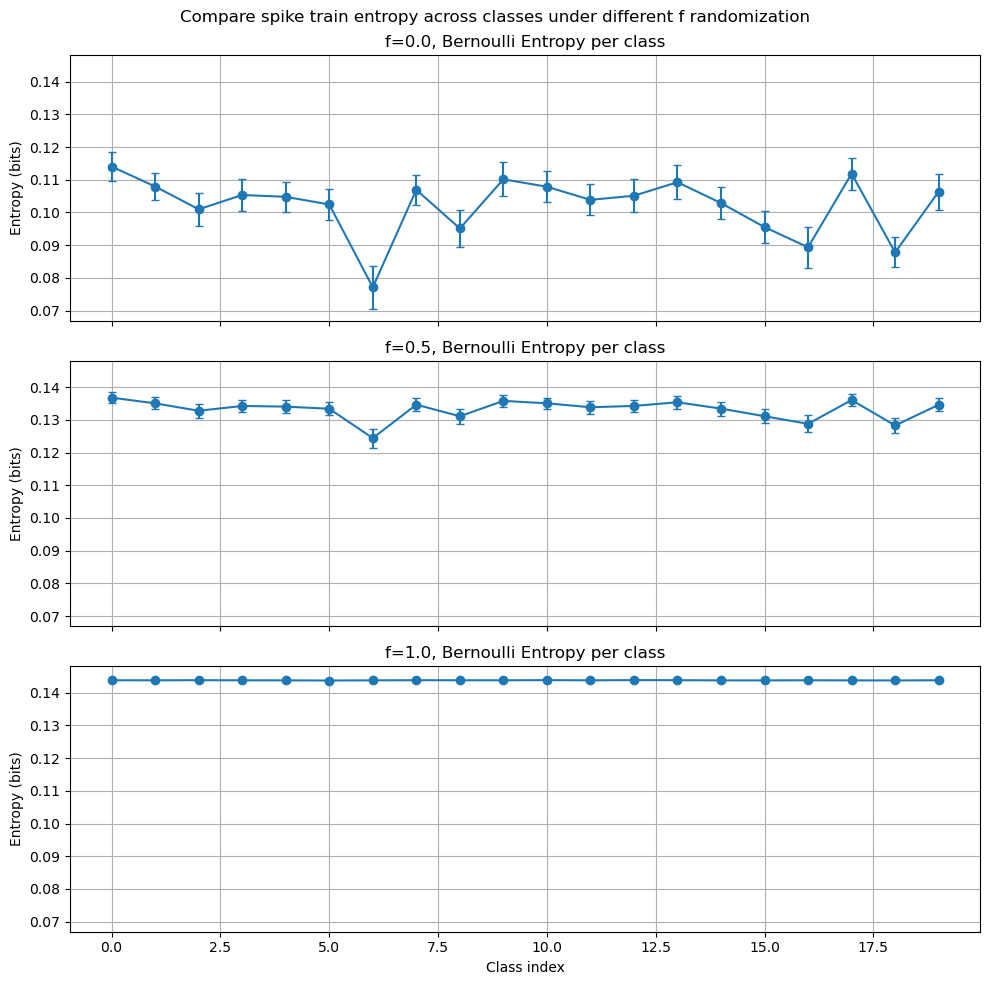

In [60]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
import math

# 1) 载入 spike data
data = io.loadmat("spikedata4_3.mat")
X = data["X"]  # shape: (N, num_neurons, T)
Y = data["Y"].ravel()
N, num_neurons, T = X.shape
print(f"Loaded dataset: X=({N},{num_neurons},{T}), Y=({len(Y)})")

num_classes = 20
print("Unique classes:", np.unique(Y))

# 2) 定义一个函数 partial_randomize_dataset(X, f)
#    将数据集中每个样本、每个神经元的 spike 随机打乱 f%
def partial_randomize_spike_train(spike_train, f=0.5, max_attempts=500):
    if f <= 0:
        return spike_train
    num_neurons, T = spike_train.shape
    new_train = np.copy(spike_train)

    for neuron_idx in range(num_neurons):
        # 找到该神经元所有脉冲的时刻
        spike_times = np.where(spike_train[neuron_idx] == 1)[0]
        for old_time in spike_times:
            # 以概率 f 决定是否移动这个 spike
            if np.random.rand() < f:
                # 1) 先把旧位置的脉冲清除
                new_train[neuron_idx, old_time] = 0
                # 2) 在新的时间位置插入
                inserted = False
                attempts = 0
                while not inserted and attempts < max_attempts:
                    attempts += 1
                    new_t = np.random.randint(0, T)  # 随机一个新时刻
                    if new_train[neuron_idx, new_t] == 0:
                        new_train[neuron_idx, new_t] = 1
                        inserted = True
    return new_train

def partial_randomize_dataset(X, f=0.5, max_attempts=50):
    """
    对整个数据 (N, num_neurons, T) 做 partial randomization
    """
    N, F, TT = X.shape
    newX = np.zeros_like(X)
    for i in range(N):
        newX[i] = partial_randomize_spike_train(X[i], f=f, max_attempts=max_attempts)
    return newX

# 3) 定义 compute_sample_entropy: 
#    采用 Bernoulli entropy => p = (#spike / (F*T)), H = -p log2 p - (1-p) log2(1-p)
def compute_sample_entropy(spike_train):
    """
    spike_train.shape = (num_neurons, T)
    返回 "per-time bin" 的Bernoulli熵之平均
    p_t = (#active neurons at time t) / num_neurons
    H_time = (1/T)* sum_{t} [ -p_t log2(p_t) - (1-p_t)log2(1-p_t) ]
    """
    F, TT = spike_train.shape
    H_sum = 0.0
    for t in range(TT):
        cnt = spike_train[:, t].sum()  # 这个时刻的总spike数
        if cnt <= 0 or cnt >= F:
            # p=0 or 1 => entropy=0
            continue
        p_t = cnt / F
        H_t = -p_t*math.log2(p_t) - (1-p_t)*math.log2(1-p_t)
        H_sum += H_t
    return H_sum / TT  # 取平均

# 4) 计算并可视化: 对 f in [0,0.5,1.0] 做 partial randomization => compute each class entropy
f_values = [0.0, 0.5, 1.0]

# 准备一个 2D 容器: class_mean_entropy[f_idx, c]
class_mean_entropy = np.zeros((len(f_values), num_classes))
class_std_entropy  = np.zeros((len(f_values), num_classes))
class_counts       = np.zeros((num_classes,), dtype=int)

for f_idx, f in enumerate(f_values):
    print(f"\n=== Analyzing f={f} ===")
    # 1) 构造扰动后数据
    if f <= 0:
        X_perturb = X
    else:
        X_perturb = partial_randomize_dataset(X, f=f)

    # 2) 按类别计算熵
    for c in range(num_classes):
        idxs_c = np.where(Y == c)[0]
        class_counts[c] = len(idxs_c)
        if len(idxs_c) == 0:
            class_mean_entropy[f_idx, c] = 0
            class_std_entropy[f_idx, c]  = 0
            continue

        sample_entropies = []
        for idx in idxs_c:
            ent = compute_sample_entropy(X_perturb[idx])
            sample_entropies.append(ent)
        sample_entropies = np.array(sample_entropies)
        class_mean_entropy[f_idx, c] = sample_entropies.mean()
        class_std_entropy[f_idx, c]  = sample_entropies.std()

# 打印
print("class_counts:", class_counts)

# 画图: 3行(对应f=0,0.5,1.0), 每行 1 subplot => x轴: class, y轴: entropy
fig, axes = plt.subplots(len(f_values), 1, figsize=(10, 10), sharex=True, sharey=True)

for f_idx, f in enumerate(f_values):
    ax = axes[f_idx]
    x_axis = np.arange(num_classes)
    means = class_mean_entropy[f_idx]
    stds  = class_std_entropy[f_idx]
    ax.errorbar(x_axis, means, yerr=stds, fmt='-o', capsize=3)
    ax.set_title(f"f={f}, Bernoulli Entropy per class")
    ax.set_ylabel("Entropy (bits)")
    ax.grid(True)

axes[-1].set_xlabel("Class index")
plt.suptitle("Compare spike train entropy across classes under different f randomization")
plt.tight_layout()
plt.show()


Loaded dataset: X=(5460,224,100), Y=(5460)
Unique classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]

=== Analyzing f=0.0 ===

=== Analyzing f=0.1 ===

=== Analyzing f=0.2 ===

=== Analyzing f=0.3 ===

=== Analyzing f=0.4 ===

=== Analyzing f=0.5 ===

=== Analyzing f=0.6 ===

=== Analyzing f=0.7 ===

=== Analyzing f=0.8 ===

=== Analyzing f=0.9 ===

=== Analyzing f=1.0 ===
class_counts: [273 273 273 273 273 273 273 273 273 273 273 273 273 273 273 273 273 273
 273 273]


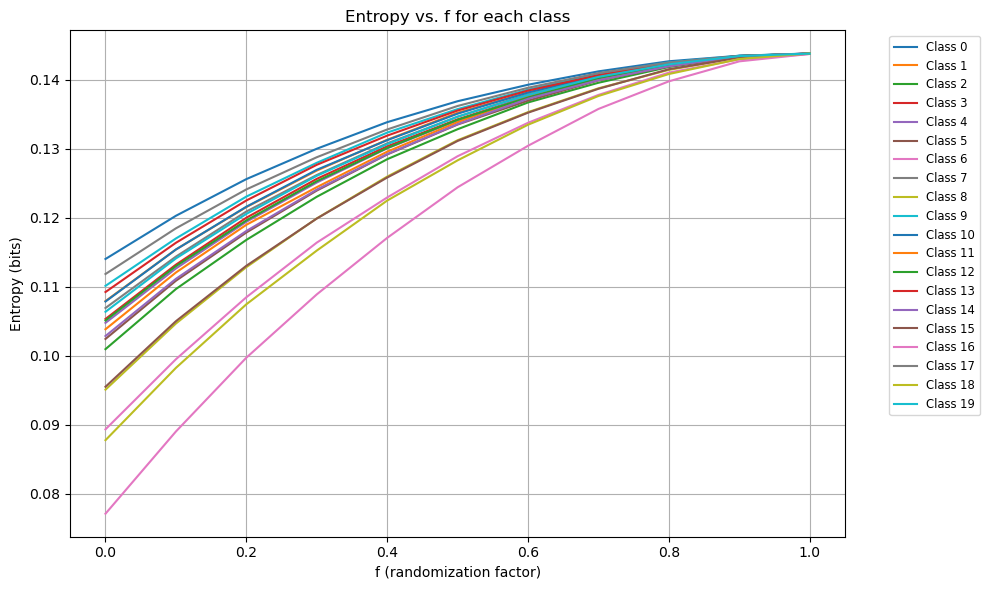

In [61]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
import math

# 1) 载入 spike data
data = io.loadmat("spikedata4_3.mat")
X = data["X"]  # shape: (N, num_neurons, T)
Y = data["Y"].ravel()
N, num_neurons, T = X.shape
print(f"Loaded dataset: X=({N},{num_neurons},{T}), Y=({len(Y)})")

num_classes = 20
print("Unique classes:", np.unique(Y))

# 2) 定义一个函数 partial_randomize_dataset(X, f)
#    将数据集中每个样本、每个神经元的 spike 随机打乱 f%
def partial_randomize_spike_train(spike_train, f=0.5, max_attempts=500):
    if f <= 0:
        return spike_train
    num_neurons, T = spike_train.shape
    new_train = np.copy(spike_train)

    for neuron_idx in range(num_neurons):
        # 找到该神经元所有脉冲的时刻
        spike_times = np.where(spike_train[neuron_idx] == 1)[0]
        for old_time in spike_times:
            # 以概率 f 决定是否移动这个 spike
            if np.random.rand() < f:
                # 1) 先把旧位置的脉冲清除
                new_train[neuron_idx, old_time] = 0
                # 2) 在新的时间位置插入
                inserted = False
                attempts = 0
                while not inserted and attempts < max_attempts:
                    attempts += 1
                    new_t = np.random.randint(0, T)  # 随机一个新时刻
                    if new_train[neuron_idx, new_t] == 0:
                        new_train[neuron_idx, new_t] = 1
                        inserted = True
    return new_train

def partial_randomize_dataset(X, f=0.5, max_attempts=50):
    """
    对整个数据 (N, num_neurons, T) 做 partial randomization
    """
    N, F, TT = X.shape
    newX = np.zeros_like(X)
    for i in range(N):
        newX[i] = partial_randomize_spike_train(X[i], f=f, max_attempts=max_attempts)
    return newX

# 3) 定义 compute_sample_entropy: 
#    采用 Bernoulli entropy => p = (#spike / (F*T)), H = -p log2 p - (1-p) log2(1-p)
def compute_sample_entropy(spike_train):
    """
    spike_train.shape = (num_neurons, T)
    返回 "per-time bin" 的Bernoulli熵之平均
    p_t = (#active neurons at time t) / num_neurons
    H_time = (1/T)* sum_{t} [ -p_t log2(p_t) - (1-p_t)log2(1-p_t) ]
    """
    F, TT = spike_train.shape
    H_sum = 0.0
    for t in range(TT):
        cnt = spike_train[:, t].sum()  # 这个时刻的总spike数
        if cnt <= 0 or cnt >= F:
            # p=0 or 1 => entropy=0
            continue
        p_t = cnt / F
        H_t = -p_t*math.log2(p_t) - (1-p_t)*math.log2(1-p_t)
        H_sum += H_t
    return H_sum / TT  # 取平均

# 4) 计算并可视化: 对 f in [0,0.5,1.0] 做 partial randomization => compute each class entropy
f_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# 准备一个 2D 容器: class_mean_entropy[f_idx, c]
class_mean_entropy = np.zeros((len(f_values), num_classes))
class_std_entropy  = np.zeros((len(f_values), num_classes))
class_counts       = np.zeros((num_classes,), dtype=int)

for f_idx, f in enumerate(f_values):
    print(f"\n=== Analyzing f={f} ===")
    # 1) 构造扰动后数据
    if f <= 0:
        X_perturb = X
    else:
        X_perturb = partial_randomize_dataset(X, f=f)

    # 2) 按类别计算熵
    for c in range(num_classes):
        idxs_c = np.where(Y == c)[0]
        class_counts[c] = len(idxs_c)
        if len(idxs_c) == 0:
            class_mean_entropy[f_idx, c] = 0
            class_std_entropy[f_idx, c]  = 0
            continue

        sample_entropies = []
        for idx in idxs_c:
            ent = compute_sample_entropy(X_perturb[idx])
            sample_entropies.append(ent)
        sample_entropies = np.array(sample_entropies)
        class_mean_entropy[f_idx, c] = sample_entropies.mean()
        class_std_entropy[f_idx, c]  = sample_entropies.std()

# 打印
print("class_counts:", class_counts)

# 画图: 横轴为 f，纵轴为 entropy，每条曲线代表一个类别
fig, ax = plt.subplots(figsize=(10, 6))

x_axis = f_values  # 横轴为 f
for c in range(num_classes):
    y_axis = class_mean_entropy[:, c]  # 每个类别对应的熵值
    ax.plot(x_axis, y_axis, label=f"Class {c}")

ax.set_title("Entropy vs. f for each class")
ax.set_xlabel("f (randomization factor)")
ax.set_ylabel("Entropy (bits)")
ax.grid(True)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')  # 图例放在右侧
plt.tight_layout()
plt.show()

Loaded dataset: X=(5460,224,100), Y=(5460)


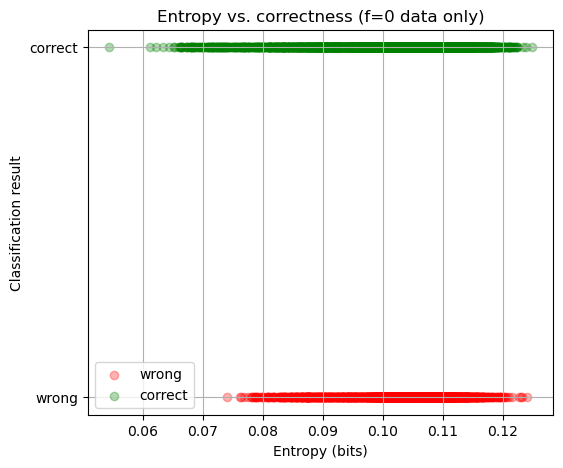

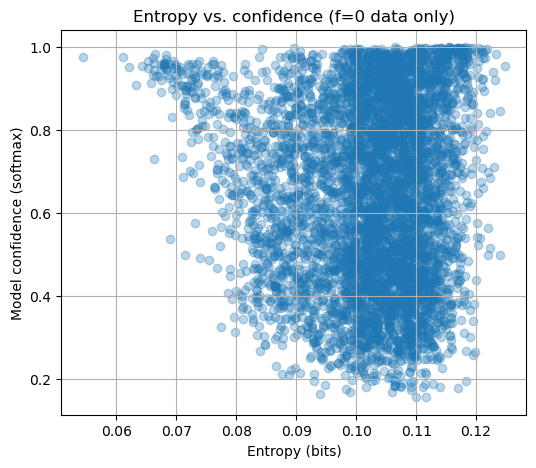

Pearson correlation (entropy, confidence) = -0.0220


In [62]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
import math

###############################################################################
# 1) 载入数据 & 模型
###############################################################################
data = io.loadmat("spikedata4_3.mat")
X_data = data["X"]  # (N, num_neurons, T)
Y_data = data["Y"].ravel()
N, num_neurons, T = X_data.shape
print(f"Loaded dataset: X=({N},{num_neurons},{T}), Y=({len(Y_data)})")

num_classes = 20  
model_path = "s4_3_f00.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# net = TutorialSNN(nb_inputs=num_neurons, nb_hidden=200, nb_outputs=num_classes).to(device)
# net.load_state_dict(torch.load(model_path, map_location=device))
# net.eval()

###############################################################################
# 2) 定义 sample 熵计算: 每个时间步做 Bernoulli => 取平均
###############################################################################
def compute_sample_entropy_timewise(spike_train):
    """
    spike_train.shape=(num_neurons, T)
    return "timewise" Bernoulli熵 => average across T
    """
    F, TT = spike_train.shape
    H_sum = 0.0
    for t in range(TT):
        cnt = spike_train[:, t].sum()
        if cnt<=0 or cnt>=F:
            # p=0 or 1 => H=0
            continue
        p_t = cnt / F
        h_t = -p_t*math.log2(p_t) - (1-p_t)*math.log2(1-p_t)
        H_sum += h_t
    return H_sum / TT

###############################################################################
# 3) 对每个样本: 计算 (entropy, 是否预测正确?, 预测置信度)
###############################################################################
entropies = []
corrects  = []
confidences = []  # softmax or log-softmax

with torch.no_grad():
    for i in range(N):
        x_np = X_data[i]  # shape=(num_neurons, T)
        label = Y_data[i]

        # compute entropy
        ent_i = compute_sample_entropy_timewise(x_np)
        entropies.append(ent_i)

        # forward in net
        x_t = torch.tensor(x_np[np.newaxis], dtype=torch.float32, device=device)
        out_rec, _ = net(x_t)
        # 如果 out_rec.shape=(1, T+1, nb_outputs), 则 out_rec=out_rec[:,:-1,:]
        m, _ = torch.max(out_rec, dim=1)  # (1, nb_outputs)
        log_probs = F.log_softmax(m, dim=1) # => (1, nb_outputs)
        preds = torch.argmax(log_probs, dim=1)
        correct = (preds.item() == label)
        corrects.append(correct)

        # 置信度 = exp(log_probs[0, preds]) or top-2 margin
        conf = torch.exp(log_probs[0, preds.item()]).item()
        confidences.append(conf)

entropies = np.array(entropies)
corrects  = np.array(corrects, dtype=np.bool_)
confidences = np.array(confidences)

###############################################################################
# 4) 做散点图或相关系数
###############################################################################
# (a) correct vs. ent
plt.figure(figsize=(6,5))
plt.scatter(entropies[~corrects], np.zeros_like(entropies[~corrects])+0, alpha=0.3, color='r', label='wrong')
plt.scatter(entropies[ corrects], np.ones_like(entropies[ corrects]), alpha=0.3, color='g', label='correct')
plt.yticks([0,1], ['wrong','correct'])
plt.xlabel("Entropy (bits)")
plt.ylabel("Classification result")
plt.title("Entropy vs. correctness (f=0 data only)")
plt.grid(True)
plt.legend()
plt.show()

# (b) confidence vs. ent
plt.figure(figsize=(6,5))
plt.scatter(entropies, confidences, alpha=0.3)
plt.xlabel("Entropy (bits)")
plt.ylabel("Model confidence (softmax)")
plt.title("Entropy vs. confidence (f=0 data only)")
plt.grid(True)
plt.show()

# (c) 计算 Pearson/Spearman 相关
corr_pearson = np.corrcoef(entropies, confidences)[0,1]
print(f"Pearson correlation (entropy, confidence) = {corr_pearson:.4f}")


Loaded dataset: X=(5460,224,100), Y=(5460)


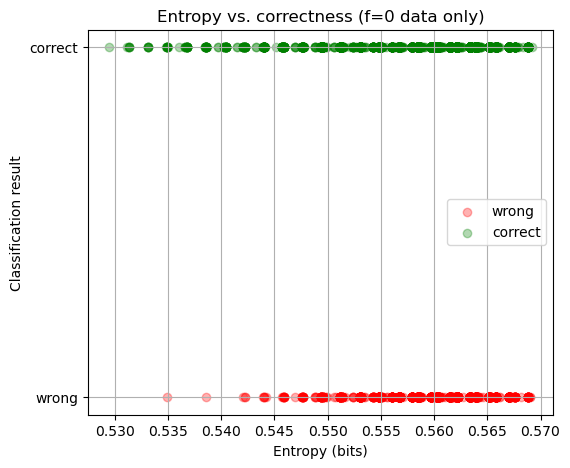

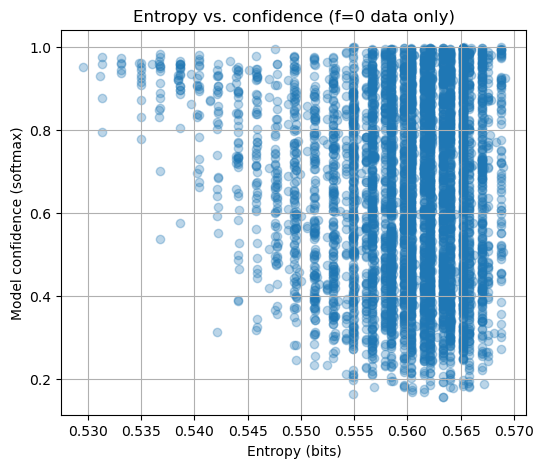

Pearson correlation (entropy, confidence) = -0.0799


In [65]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
import math

# ========== 1) 载入数据 & 模型 ==========
data = io.loadmat("spikedata4_3.mat")
X_data = data["X"]  # (N, num_neurons, T)
Y_data = data["Y"].ravel()
N, num_neurons, T = X_data.shape
print(f"Loaded dataset: X=({N},{num_neurons},{T}), Y=({len(Y_data)})")

num_classes = 20  
model_path = "s4_3_f00.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# net = TutorialSNN(nb_inputs=num_neurons, nb_hidden=200, nb_outputs=num_classes).to(device)
# net.load_state_dict(torch.load(model_path, map_location=device))
# net.eval()

# ========== 2) ISI-based 熵计算 ==========
def compute_sample_entropy_isi(spike_train, max_isi=50, bins=20):
    """
    spike_train.shape=(num_neurons, T)
    对每个神经元统计 ISI 分布，并计算其熵
    返回该样本所有 neuron 的 ISI 熵的平均值
    """
    F, T = spike_train.shape
    entropies = []

    for i in range(F):
        spike_times = np.where(spike_train[i] == 1)[0]
        if len(spike_times) < 2:
            continue
        isi = np.diff(spike_times)
        isi = isi[isi <= max_isi]
        if len(isi) == 0:
            continue
        hist, _ = np.histogram(isi, bins=bins, range=(1, max_isi), density=True)
        p = hist[hist > 0]
        H = -np.sum(p * np.log2(p))
        entropies.append(H)

    return np.mean(entropies) if len(entropies) > 0 else 0.0

# ========== 3) 对所有样本做 forward + ISI 熵分析 ==========
entropies = []
corrects = []
confidences = []

with torch.no_grad():
    for i in range(N):
        x_np = X_data[i]
        label = Y_data[i]

        ent_i = compute_sample_entropy_isi(x_np)
        entropies.append(ent_i)

        x_t = torch.tensor(x_np[np.newaxis], dtype=torch.float32, device=device)
        out_rec, _ = net(x_t)
        m, _ = torch.max(out_rec[:, :-1, :], dim=1)  # (1, nb_outputs)
        log_probs = F.log_softmax(m, dim=1)
        preds = torch.argmax(log_probs, dim=1)
        corrects.append(preds.item() == label)
        confidences.append(torch.exp(log_probs[0, preds.item()]).item())

entropies = np.array(entropies)
corrects = np.array(corrects)
confidences = np.array(confidences)

# ========== 4) 可视化 ==========
# (a) correct vs. ent
plt.figure(figsize=(6,5))
plt.scatter(entropies[~corrects], np.zeros_like(entropies[~corrects])+0, alpha=0.3, color='r', label='wrong')
plt.scatter(entropies[ corrects], np.ones_like(entropies[ corrects]), alpha=0.3, color='g', label='correct')
plt.yticks([0,1], ['wrong','correct'])
plt.xlabel("Entropy (bits)")
plt.ylabel("Classification result")
plt.title("Entropy vs. correctness (f=0 data only)")
plt.grid(True)
plt.legend()
plt.show()

# (b) confidence vs. ent
plt.figure(figsize=(6,5))
plt.scatter(entropies, confidences, alpha=0.3)
plt.xlabel("Entropy (bits)")
plt.ylabel("Model confidence (softmax)")
plt.title("Entropy vs. confidence (f=0 data only)")
plt.grid(True)
plt.show()

# (c) 计算 Pearson/Spearman 相关
corr_pearson = np.corrcoef(entropies, confidences)[0,1]
print(f"Pearson correlation (entropy, confidence) = {corr_pearson:.4f}")
